In [1]:
import warnings
warnings.filterwarnings("ignore")

import shapely                
from shapely.wkt import loads 

import pandas as pd           
import geopandas as gpd       

import numpy as np
import scipy.stats as ss
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sb  

import matplotlib.pyplot as plt 
import palettable.colorbrewer.diverging as pcd

from sklearn import datasets
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

In [2]:
my_df1 = pd.read_csv('UKCensus-21-11-London-21geog-data.csv')

In [3]:
my_df1.rename(columns={'LSOA21CD':'LSOA Code'}, inplace=True)
my_df1.rename(columns={'LSOA21NM':'LSOA Name'}, inplace=True)
my_df1.rename(columns={'MSOA21CD':'Borough'}, inplace=True)

In [4]:
my_df2 = pd.read_csv('MPS LSOA Level Crime (Historical).csv')

In [5]:
my_df3 = pd.read_csv('crime in 2021.csv')

In [6]:
dates2011 = [date for date in my_df2.columns if '2011' in date]
dates2021 = [date for date in my_df2.columns if '2021' in date]
my_df2['crime2011'] = my_df2[dates2011].sum(axis=1)
my_df3['crime2021'] = my_df3[dates2021].sum(axis=1)

my_df2 = my_df2[['LSOA Code','LSOA Name','Borough','Major Category','Minor Category','crime2011']]
my_df3 = my_df3[['LSOA Code','LSOA Name','Borough','Major Category','Minor Category','crime2021']]

In [7]:
my_df2['Crime Category'] = my_df2['Major Category'] + ' : ' + my_df2['Minor Category']

new_df2 = pd.pivot(my_df2,
                   index=['LSOA Code','LSOA Name','Borough'],
                   columns='Crime Category',
                   values='crime2011')

new_df2 = new_df2.reset_index()

In [8]:
my_df3['Crime Category'] = my_df3['Major Category'] + ' : ' + my_df3['Minor Category']

new_df3 = pd.pivot(my_df3,
                   index=['LSOA Code','LSOA Name','Borough'],
                   columns='Crime Category',
                   values='crime2021')

new_df3 = new_df3.reset_index()

In [9]:
new_df2['Total Crime 2011'] = new_df2.sum(axis=1, numeric_only=True)
new_df2 = new_df2[['LSOA Code', 'LSOA Name', 'Borough', 'Total Crime 2011']]

In [10]:
new_df3['Total Crime 2021'] = new_df3.sum(axis=1, numeric_only=True)
new_df3 = new_df3[['LSOA Code', 'LSOA Name', 'Borough', 'Total Crime 2021']]

In [11]:
final_df = pd.merge(my_df1, new_df2, on= 'LSOA Code', how='inner')

In [12]:
final_df2 = pd.merge(final_df, new_df3, on = 'LSOA Code', how = "inner")

In [13]:
Qualification_sums = final_df2.loc[:,'QualNone21':'QualUni11_m21'].sum()
Qualification_sums_reshape = Qualification_sums.values.reshape(3,2)
Qualification_sums_df = pd.DataFrame(Qualification_sums_reshape, index=['No Qualifications','School level','Bachelors Degree or higher'],columns=['2021','2011'])

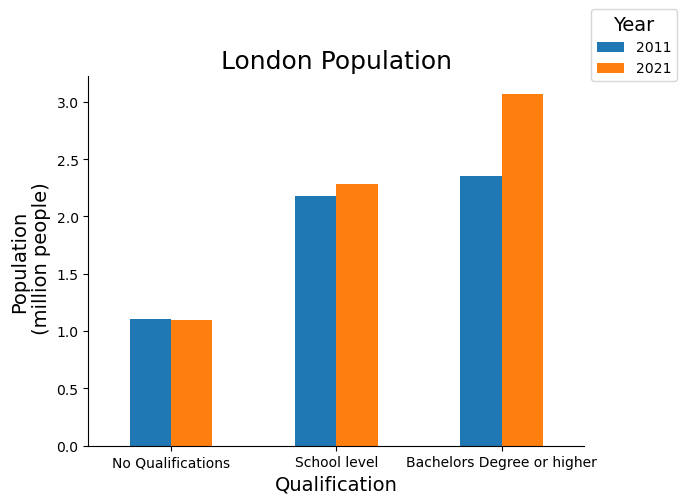

In [14]:
Qualification_sums_dfm = Qualification_sums_df/1000000
Qualification_sums_dfm = Qualification_sums_dfm[['2011', '2021']]
Qualification_sums_dfm.plot.bar()

plt.figsize=(7,4)
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1.2), title="Year", title_fontsize=14)

plt.xlabel('Qualification',fontsize=14)
plt.ylabel('Population\n (million people)',fontsize=14)
plt.xticks(rotation=0)
plt.title('London Population', fontsize=18)

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

#plt.savefig("Barplot London Qualification.png",dpi=300, bbox_inches='tight',facecolor='white')

plt.show()

In [15]:
Employment_status_sums = final_df2.loc[:,'EconEm21':'EconUn11_m21'].sum()
Employment_status_sums_reshape = Employment_status_sums.values.reshape(2,2)
Employment_status_sums_df = pd.DataFrame(Employment_status_sums_reshape, index=['Employed','Unemployed'],columns=['2021','2011'])

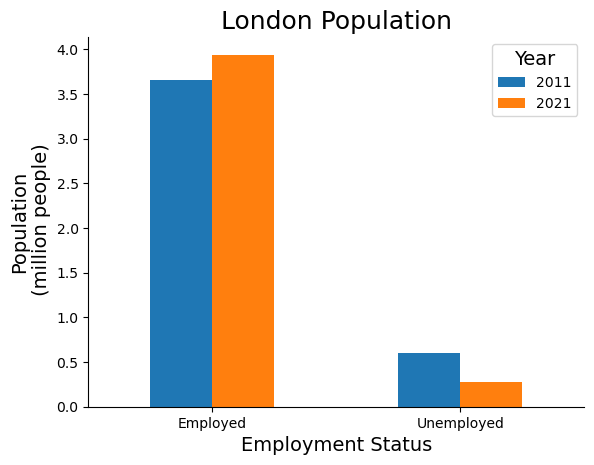

In [16]:
Employment_status_sums_dfm = Employment_status_sums_df/1000000
Employment_status_sums_dfm = Employment_status_sums_dfm[['2011', '2021']]
Employment_status_sums_dfm.plot.bar()

plt.figsize=(7,4)
plt.legend(loc='upper right', bbox_to_anchor=(1.0, 1.0), title="Year", title_fontsize=14)

plt.xlabel('Employment Status',fontsize=14)
plt.ylabel('Population\n (million people)',fontsize=14)
plt.xticks(rotation=0)
plt.title('London Population', fontsize=18)

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

#plt.savefig("Barplot London Qualification.png",dpi=300, bbox_inches='tight',facecolor='white')

plt.show()

In [17]:
Boroughs = pd.read_csv('London_Borough_Abbreviations.csv')

In [18]:
final_df3 = pd.merge(final_df2, Boroughs, how = 'left', left_on='LAD22CD', right_on='GSS_CODE')

In [19]:
Qualification_df = final_df3[['BORO',
                              'QualNone21','QualNone11_m21',
                              'QualSch21','QualSch11_m21',
                              'QualUni21','QualUni11_m21']]

Qualification_Borough_sums = Qualification_df.groupby('BORO').sum()

<Axes: xlabel='BORO'>

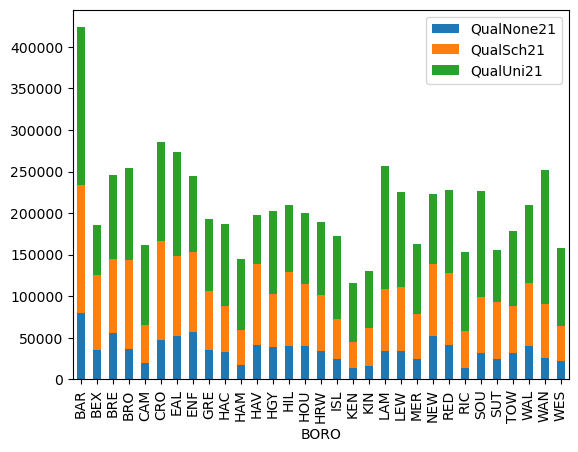

In [20]:
Qualification_Borough_sums[['QualNone21','QualSch21','QualUni21']].plot.bar(stacked=True)

In [21]:
TotRes_df = final_df3[['BORO',
                        'TotRes21','TotRes11_m21']]
Tot_Borough_sums = TotRes_df.groupby('BORO').sum()

In [22]:
Qualification_TotRes = pd.merge(Tot_Borough_sums, Qualification_Borough_sums, on= 'BORO', how='inner')

In [23]:
Qualification_TotRes['Rel_QualNone21'] = 100*Qualification_TotRes['QualNone21']/Qualification_TotRes['TotRes21']
Qualification_TotRes['Rel_QualNone11'] = 100*Qualification_TotRes['QualNone11_m21']/Qualification_TotRes['TotRes11_m21']
Qualification_TotRes['Rel_QualUni21'] = 100*Qualification_TotRes['QualUni21']/Qualification_TotRes['TotRes21']
Qualification_TotRes['Rel_QualUni11'] = 100*Qualification_TotRes['QualUni11_m21']/Qualification_TotRes['TotRes11_m21']

In [24]:
final_df3['Rel_Pop_Uni_21'] =100*final_df3['QualUni21']/final_df3['TotRes21'].abs() 
final_df3['Rel_Pop_Uni_11'] =100*final_df3['QualUni11_m21']/final_df3['TotRes11_m21'].abs()
final_df3['Rel_Pop_NoQual_21']=100*final_df3['QualNone21']/final_df3['TotRes21'].abs()
final_df3['Rel_Pop_NoQual_11']=100*final_df3['QualNone11_m21']/final_df3['TotRes11_m21'].abs()

In [25]:
borshp = pd.read_csv("London_Borough_Excluding_MHW.csv")
borshp = gpd.GeoDataFrame(borshp) 
borshp['geometry'] = borshp['geometry'].apply(lambda x: loads(x)) 
borshp = borshp.set_geometry('geometry')

In [26]:
boros = pd.merge(borshp, Boroughs, how='left', on="GSS_CODE")

In [27]:
Boroughs_Qual_TR = pd.merge(boros, Qualification_TotRes, how='left', on='BORO')

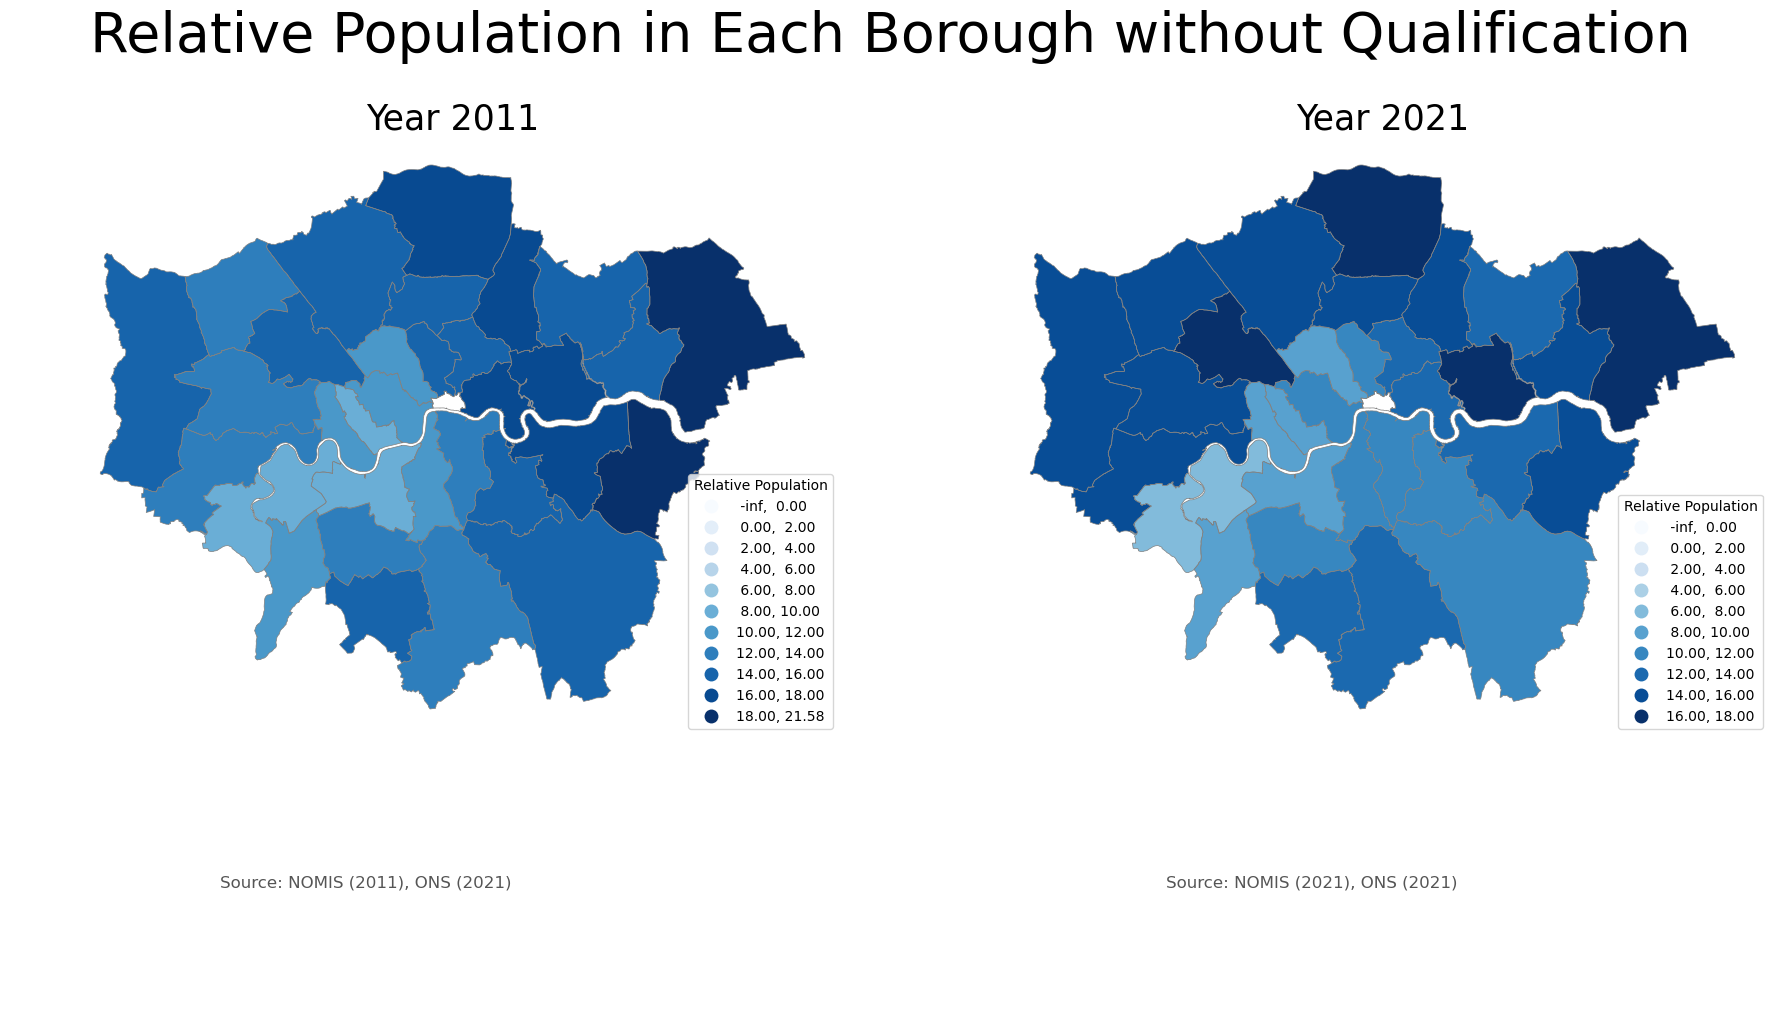

In [28]:
cbins = [x for x in range(0, 20, 2)] 

fig, axs = plt.subplots(1,2,figsize=(22,14))
    
Boroughs_Qual_TR.plot(column='Rel_QualNone11', ax=axs[0],
         scheme='UserDefined', 
         classification_kwds={'bins': cbins}, 
         cmap = 'Blues',
         edgecolor='grey', linewidth=0.0,    
         legend=True, legend_kwds={'title': "Relative Population",'loc': 'lower right'})  


borshp.plot(ax=axs[0], facecolor="none", edgecolor="grey", linewidth=0.5)
axs[0].axis('off') 
axs[0].set_title('Year 2011', fontsize=25) 
axs[0].annotate('Source: NOMIS (2011), ONS (2021)',
             xy=(0.1, 0.1), xycoords='figure fraction', 
             horizontalalignment='left', verticalalignment='top', 
             fontsize=12, color='#555555') 

#plt.savefig("img/Map_LSOAs_PerD_11-21.png", dpi=300, bbox_inches='tight', facecolor='white')
#plt.savefig("img/Map_LSOAs_PerD_11-21.svg", bbox_inches='tight', facecolor='white')


Boroughs_Qual_TR.plot(column='Rel_QualNone21', ax=axs[1],
         scheme='UserDefined', 
         classification_kwds={'bins': cbins},  
         cmap = 'Blues',
         edgecolor='grey', linewidth=0.0,       
         legend=True, legend_kwds={'title': "Relative Population",'loc': 'lower right'})  


borshp.plot(ax=axs[1], facecolor="none", edgecolor="grey", linewidth=0.5)
axs[1].axis('off') #don't plot the axes (bounding box)
axs[1].set_title('Year 2021', fontsize=25)  #provide a title
axs[1].annotate('Source: NOMIS (2021), ONS (2021)',
             xy=(0.53, 0.1), xycoords='figure fraction', 
             horizontalalignment='left', verticalalignment='top', 
             fontsize=12, color='#555555')
    
plt.suptitle('Relative Population in Each Borough without Qualification', fontsize=40, y=0.80)
plt.savefig("Relative Population in each Borough without Qualification", dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

In [29]:
Qualification_TotRes['Diff_NoQual']= Qualification_TotRes['Rel_QualNone21']-Qualification_TotRes['Rel_QualNone11']
Qualification_TotRes['RC_NoQual']= 100*Qualification_TotRes['Diff_NoQual']/Qualification_TotRes['Rel_QualNone11']

In [30]:
Boroughs_Qual_TR2 = pd.merge(Boroughs_Qual_TR, Qualification_TotRes, how='left', on='BORO')

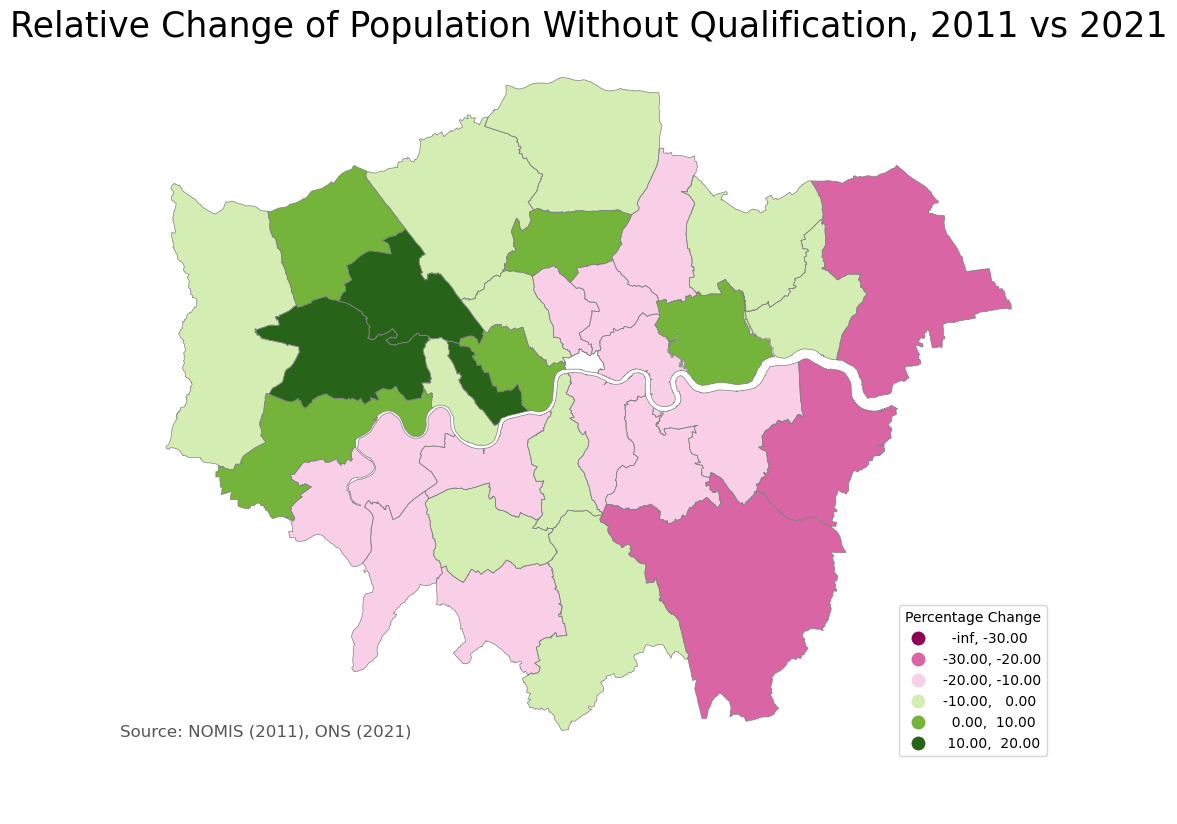

In [31]:
cbins = [x for x in range(-30, 30, 10)] 

fig, ax1 = plt.subplots(1, figsize=(12, 10))   
Boroughs_Qual_TR2.plot(column='RC_NoQual', ax=ax1,
         scheme='UserDefined', 
         classification_kwds={'bins': cbins},  
         cmap = pcd.PiYG_10.mpl_colormap,
         edgecolor='grey', linewidth=0.0,       
         legend=True, legend_kwds={'title': "Percentage Change",'loc': 'lower right'})  

borshp.plot(ax=ax1, facecolor="none", edgecolor="grey", linewidth=0.5)
ax1.axis('off') 
plt.title('Relative Change of Population Without Qualification, 2011 vs 2021', fontsize=25)  
ax1.annotate('Source: NOMIS (2011), ONS (2021)',
             xy=(0.1, 0.1), xycoords='figure fraction', 
             horizontalalignment='left', verticalalignment='top', 
             fontsize=12, color='#555555')  

plt.savefig("No Qualification Relative Change.png", dpi=300, bbox_inches='tight', facecolor='white')
#plt.savefig("img/Map_LSOAs_PerD_11-21.svg", bbox_inches='tight', facecolor='white')

plt.show()

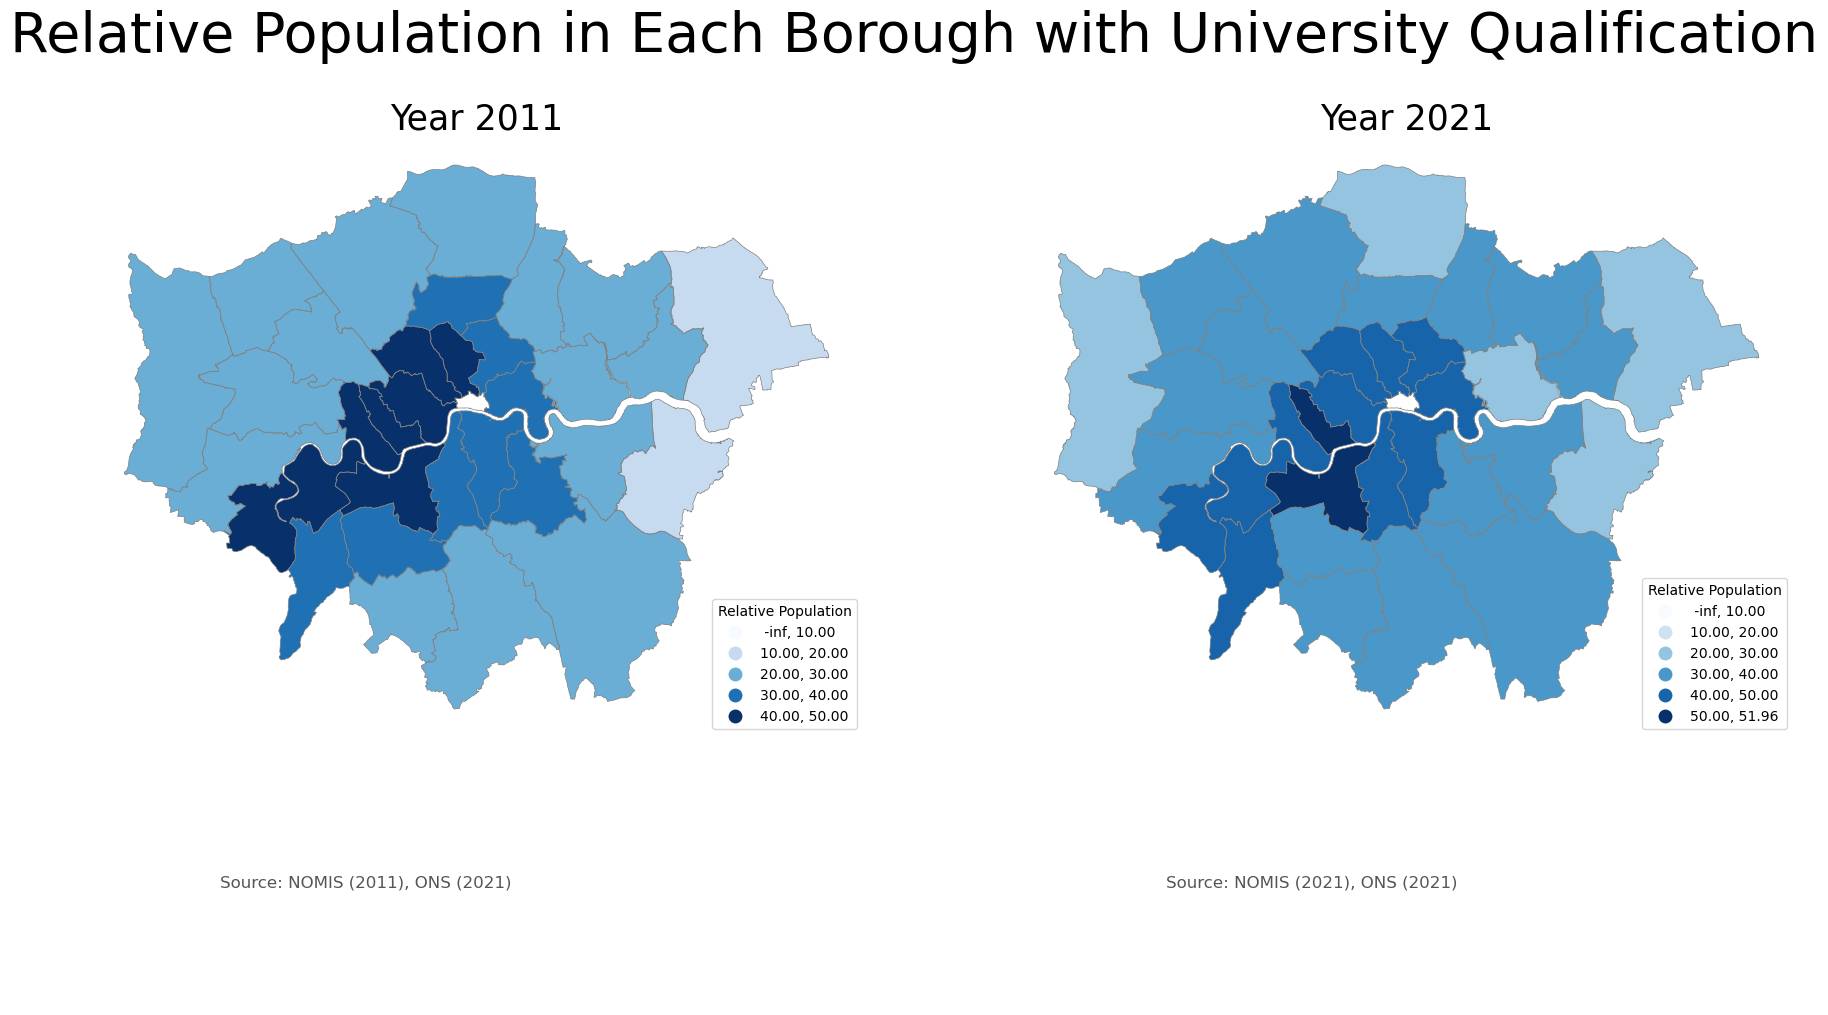

In [32]:
cbins = [x for x in range(10, 60, 10)]  

fig, axs = plt.subplots(1,2,figsize=(22,14))
Boroughs_Qual_TR.plot(column='Rel_QualUni11', ax=axs[0],
         scheme='UserDefined', 
         classification_kwds={'bins': cbins}, 
         cmap = 'Blues',
         edgecolor='grey', linewidth=0.0,       
         legend=True, legend_kwds={'title': "Relative Population",'loc': 'lower right'})  

borshp.plot(ax=axs[0], facecolor="none", edgecolor="grey", linewidth=0.5)
axs[0].axis('off')
axs[0].set_title('Year 2011', fontsize=25) 
axs[0].annotate('Source: NOMIS (2011), ONS (2021)',
             xy=(0.1, 0.1), xycoords='figure fraction', 
             horizontalalignment='left', verticalalignment='top', 
             fontsize=12, color='#555555') 

#plt.savefig("img/Map_LSOAs_PerD_11-21.png", dpi=300, bbox_inches='tight', facecolor='white')
#plt.savefig("img/Map_LSOAs_PerD_11-21.svg", bbox_inches='tight', facecolor='white')



Boroughs_Qual_TR.plot(column='Rel_QualUni21', ax=axs[1],
         scheme='UserDefined', 
         classification_kwds={'bins': cbins},  
         cmap = 'Blues',
         edgecolor='grey', linewidth=0.0,    
         legend=True, legend_kwds={'title': "Relative Population",'loc': 'lower right'})  


borshp.plot(ax=axs[1], facecolor="none", edgecolor="grey", linewidth=0.5)
axs[1].axis('off')
axs[1].set_title('Year 2021', fontsize=25) 
axs[1].annotate('Source: NOMIS (2021), ONS (2021)',
             xy=(0.53, 0.1), xycoords='figure fraction', 
             horizontalalignment='left', verticalalignment='top', 
             fontsize=12, color='#555555')
    
plt.suptitle('Relative Population in Each Borough with University Qualification', fontsize=40, y=0.80)
plt.show()

In [33]:
Qualification_TotRes['Diff_Uni']= Qualification_TotRes['Rel_QualUni21']-Qualification_TotRes['Rel_QualUni11']
Qualification_TotRes['RC_Uni']= 100*Qualification_TotRes['Diff_Uni']/Qualification_TotRes['Rel_QualUni11']

In [34]:
Boroughs_Qual_TR2 = pd.merge(Boroughs_Qual_TR, Qualification_TotRes, how='left', on='BORO')

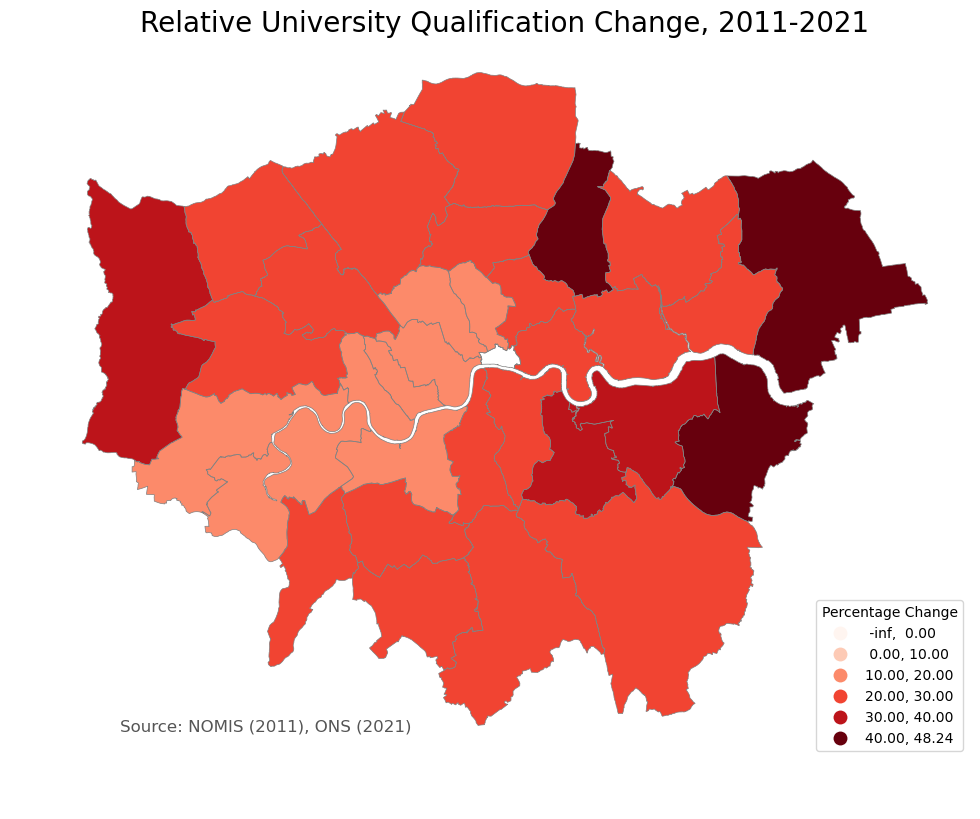

In [35]:
cbins = [x for x in range(0,50, 10)] 

fig, ax1 = plt.subplots(1, figsize=(12, 10))   
Boroughs_Qual_TR2.plot(column='RC_Uni', ax=ax1,
         scheme='UserDefined', 
         classification_kwds={'bins': cbins},  
         cmap = 'Reds',
         edgecolor='grey', linewidth=0.0,        
         legend=True, legend_kwds={'title': "Percentage Change",'loc': 'lower right'})  

borshp.plot(ax=ax1, facecolor="none", edgecolor="grey", linewidth=0.5)
ax1.axis('off')
plt.title('Relative University Qualification Change, 2011-2021', fontsize=20) 

ax1.annotate('Source: NOMIS (2011), ONS (2021)',
             xy=(0.1, 0.1), xycoords='figure fraction', 
             horizontalalignment='left', verticalalignment='top', 
             fontsize=12, color='#555555')  

#plt.savefig("img/Map_LSOAs_PerD_11-21.png", dpi=300, bbox_inches='tight', facecolor='white')
#plt.savefig("img/Map_LSOAs_PerD_11-21.svg", bbox_inches='tight', facecolor='white')

plt.show()

In [36]:
lsoa_gdf = gpd.GeoDataFrame(final_df3)
lsoa_gdf['geometry'] = lsoa_gdf['geometry'].apply(lambda x: loads(x))
lsoa_gdf = lsoa_gdf.set_geometry('geometry')

In [37]:
lsoa_gdf['Diff_NoQual']=lsoa_gdf['Rel_Pop_NoQual_21']-lsoa_gdf['Rel_Pop_NoQual_11']
lsoa_gdf['RC_NoQual']=100*lsoa_gdf['Diff_NoQual']/lsoa_gdf['Rel_Pop_NoQual_11']

In [38]:
lsoa_gdf['Diff_Uni']=lsoa_gdf['Rel_Pop_Uni_21']-lsoa_gdf['Rel_Pop_Uni_11']
lsoa_gdf['RC_Uni']=100*lsoa_gdf['Diff_Uni']/lsoa_gdf['Rel_Pop_Uni_11']

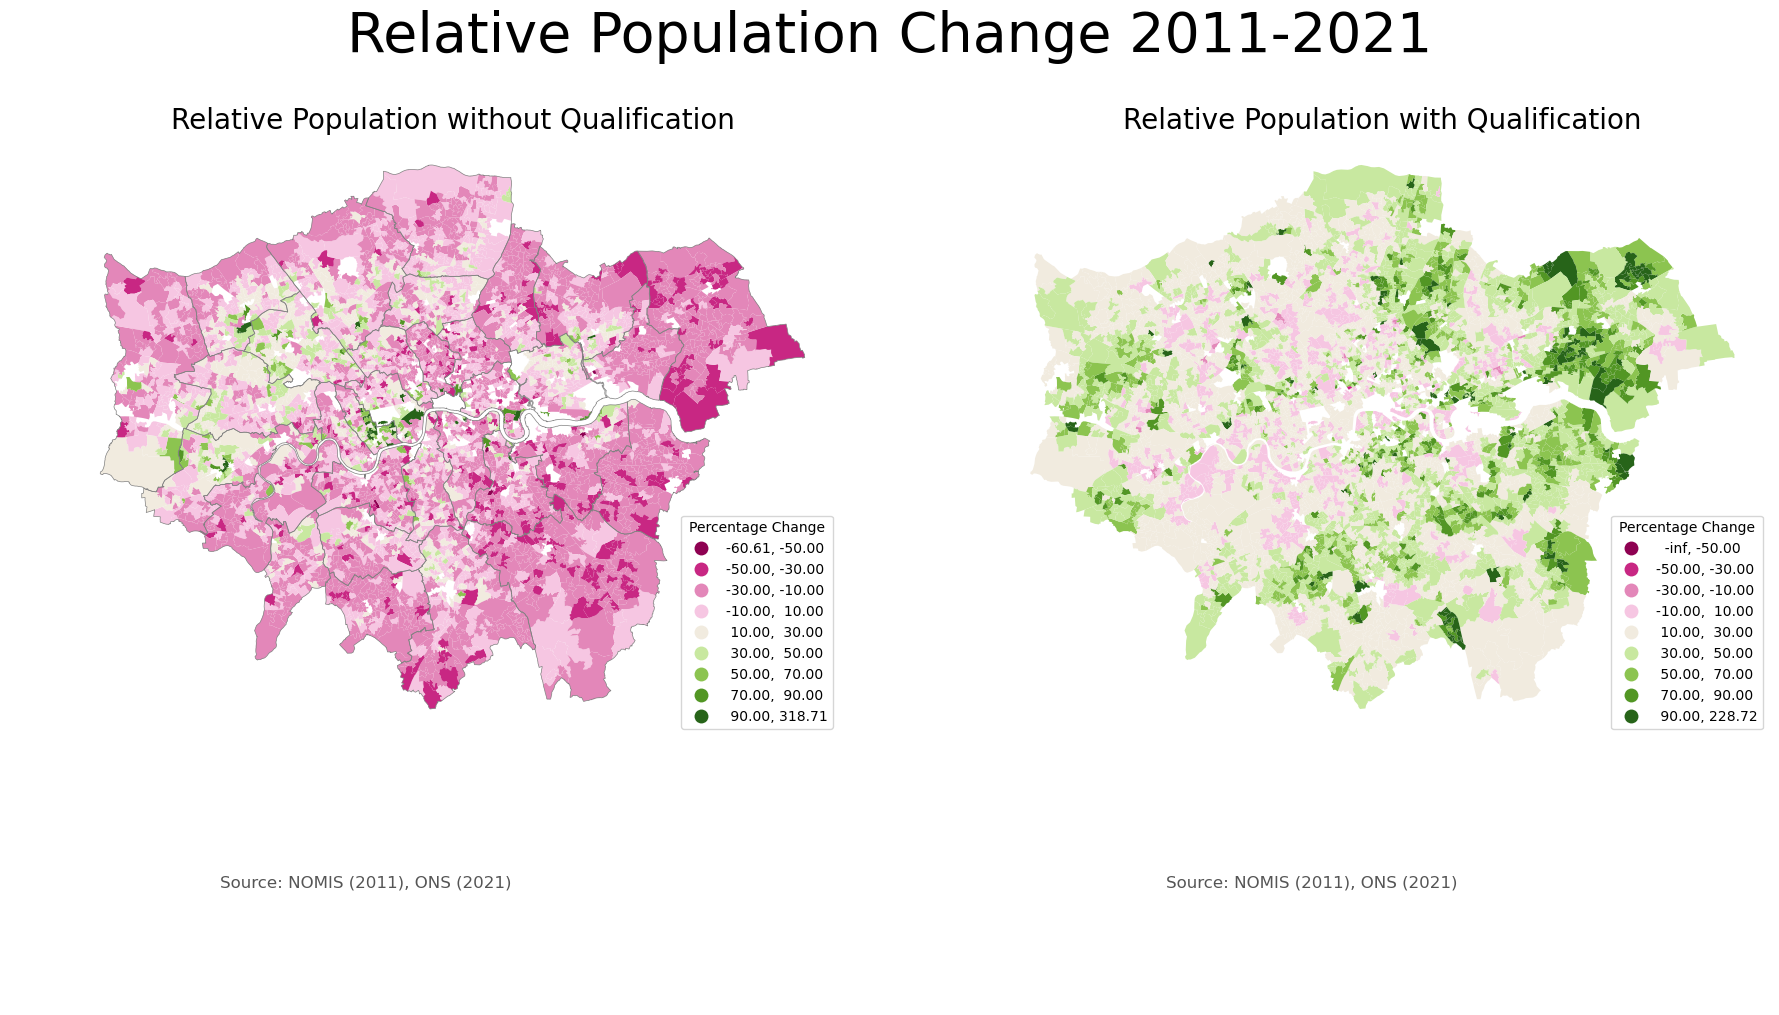

In [39]:
cbins = [x for x in range(-50, 100, 20)] 

fig, axs = plt.subplots(1,2, figsize=(22, 14))   
lsoa_gdf.plot(column='RC_NoQual', ax=axs[0],
         scheme='UserDefined', 
         classification_kwds={'bins': cbins},  #Keyword arguments to pass to mapclassify
         cmap = pcd.PiYG_10.mpl_colormap,
         edgecolor='grey', linewidth=0.0,        #change line style
         legend=True, legend_kwds={'title': "Percentage Change",'loc': 'lower right'},
              missing_kwds={"color":"lightgrey",
                           "label":"Split LSOAs"})  

#overlay the borough boundaries
borshp.plot(ax=axs[0], facecolor="none", edgecolor="grey", linewidth=0.5)

axs[0].axis('off') #don't plot the axes (bounding box)

axs[0].set_title('Relative Population without Qualification', fontsize=20)  #provide a title

axs[0].annotate('Source: NOMIS (2011), ONS (2021)',
             xy=(0.1, 0.1), xycoords='figure fraction', 
             horizontalalignment='left', verticalalignment='top', 
             fontsize=12, color='#555555')  #add source info on the image itself

  
lsoa_gdf.plot(column='RC_Uni', ax=axs[1],
         scheme='UserDefined', 
         classification_kwds={'bins': cbins},  #Keyword arguments to pass to mapclassify
         cmap = pcd.PiYG_10.mpl_colormap,
         edgecolor='grey', linewidth=0.0,        #change line style
         legend=True, legend_kwds={'title': "Percentage Change",'loc': 'lower right'},
             missing_kwds={"color":"lightgrey",
                           "label":"Split LSOAs"})  

#overlay the borough boundaries
borshp.plot(ax=ax1, facecolor="none", edgecolor="grey", linewidth=0.5)

axs[1].axis('off') #don't plot the axes (bounding box)
axs[1].set_title('Relative Population with Qualification', fontsize=20)  #provide a title
axs[1].annotate('Source: NOMIS (2011), ONS (2021)',
             xy=(0.53, 0.1), xycoords='figure fraction', 
             horizontalalignment='left', verticalalignment='top', 
             fontsize=12, color='#555555')

plt.suptitle('Relative Population Change 2011-2021', fontsize=40, y=0.80)
plt.savefig("Relative Pop Change Qualification LSOA.png", dpi=300, bbox_inches='tight', facecolor='white')
#plt.savefig("img/Map_LSOAs_PerD_11-21.svg", bbox_inches='tight', facecolor='white')
plt.show()

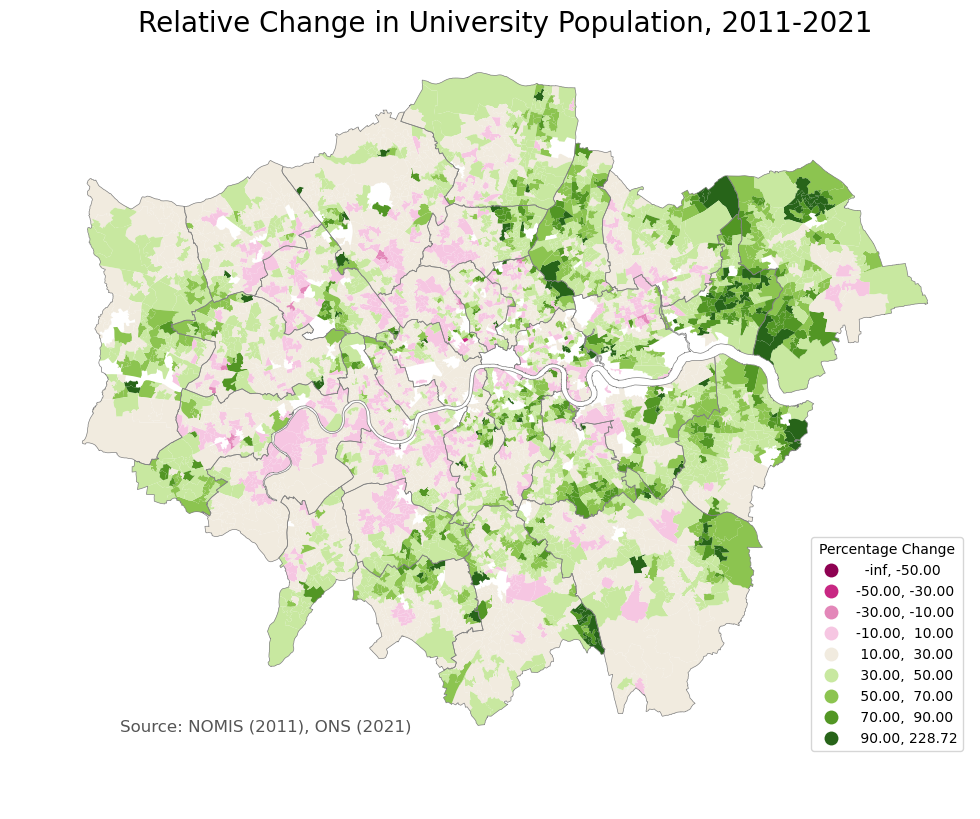

In [40]:
cbins = [x for x in range(-50, 100, 20)] 

fig, ax1 = plt.subplots(1, figsize=(12, 10))   
lsoa_gdf.plot(column='RC_Uni', ax=ax1,
         scheme='UserDefined', 
         classification_kwds={'bins': cbins},  #Keyword arguments to pass to mapclassify
         cmap = pcd.PiYG_10.mpl_colormap,
         edgecolor='grey', linewidth=0.0,        #change line style
         legend=True, legend_kwds={'title': "Percentage Change",'loc': 'lower right'},
             missing_kwds={"color":"lightgrey",
                           "label":"Split LSOAs"})  

#overlay the borough boundaries
borshp.plot(ax=ax1, facecolor="none", edgecolor="grey", linewidth=0.5)

ax1.axis('off') #don't plot the axes (bounding box)

plt.title('Relative Change in University Population, 2011-2021', fontsize=20)  #provide a title

ax1.annotate('Source: NOMIS (2011), ONS (2021)',
             xy=(0.1, 0.1), xycoords='figure fraction', 
             horizontalalignment='left', verticalalignment='top', 
             fontsize=12, color='#555555')  #add source info on the image itself

#plt.savefig("img/Map_LSOAs_PerD_11-21.png", dpi=300, bbox_inches='tight', facecolor='white')
#plt.savefig("img/Map_LSOAs_PerD_11-21.svg", bbox_inches='tight', facecolor='white')

plt.show()

In [41]:
print(lsoa_gdf.columns)

Index(['LSOA Code', 'LSOA Name_x', 'Borough_x', 'MSOA21NM', 'LAD22CD',
       'LAD22NM', 'LSOA21KM2', 'LSOAP21', 'CHGIND', 'geometry', 'TotRes21',
       'TotRes11_m21', 'TotHHolds21', 'TotHHolds11_m21', 'FemRes21',
       'FemRes11_m21', 'MalRes21', 'MalRes11_m21', 'Asian21', 'Asian11_m21',
       'Black21', 'Black11_m21', 'MixedE21', 'MixedE11_m21', 'White21',
       'White11_m21', 'OtherE21', 'OtherE11_m21', 'CarsZero21',
       'CarsZero11_m21', 'CarsOne21', 'CarsOne11_m21', 'CarsTwo21',
       'CarsTwo11_m21', 'CarsThrp21', 'CarsThrp11_m21', 'EconEm21',
       'EconEm11_m21', 'EconUn21', 'EconUn11_m21', 'EconSt21', 'EconSt11_m21',
       'EconRe21', 'EconRe11_m21', 'EconOt21', 'EconOt11_m21', 'AgeChild21',
       'AgeChild11_m21', 'AgeAdult21', 'AgeAdult11_m21', 'AgeSenior21',
       'AgeSenior11_m21', 'HealthVG21', 'HealthVG11_m21', 'HealthGood21',
       'HealthGood11_m21', 'HealthFair21', 'HealthFair11_m21', 'HealthBad21',
       'HealthBad11_m21', 'HealthVB21', 'HealthVB11_m21

In [42]:
lsoa_gdf['Diff_Crime']=lsoa_gdf['Total Crime 2021']-lsoa_gdf['Total Crime 2011']
lsoa_gdf['RC_Crime']=100*lsoa_gdf['Diff_Crime']/lsoa_gdf['Total Crime 2011']

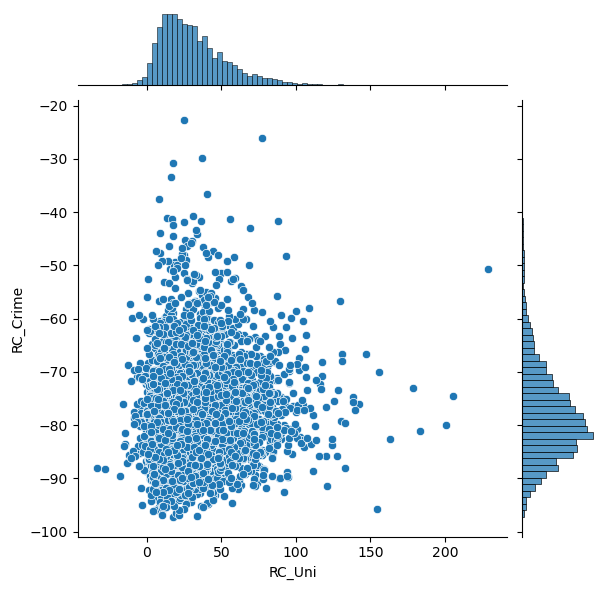

In [43]:
sb.jointplot(x="RC_Uni", y="RC_Crime", data=lsoa_gdf)

In [44]:
print(ss.pearsonr(lsoa_gdf['RC_Uni'].dropna(),lsoa_gdf['RC_Crime'].dropna()))

PearsonRResult(statistic=0.1183464582028273, pvalue=5.53844371980553e-16)


In [45]:
Uni_Crime_mod = smf.ols("RC_Uni ~ RC_Crime", data = lsoa_gdf) 
Uni_Crime_mod_fit = Uni_Crime_mod.fit()
print(Uni_Crime_mod_fit.summary())

                            OLS Regression Results                            
Dep. Variable:                 RC_Uni   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     66.07
Date:                Mon, 15 Jan 2024   Prob (F-statistic):           5.54e-16
Time:                        19:26:00   Log-Likelihood:                -21254.
No. Observations:                4653   AIC:                         4.251e+04
Df Residuals:                    4651   BIC:                         4.252e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     56.9799      3.120     18.263      0.0

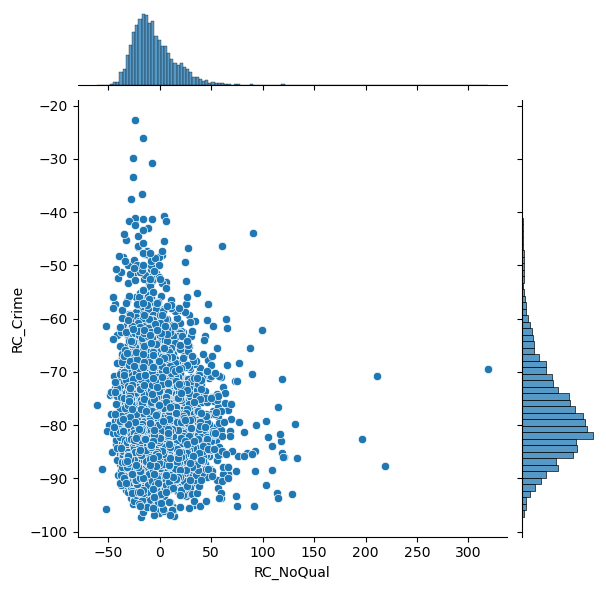

In [46]:
sb.jointplot(x="RC_NoQual", y="RC_Crime", data=lsoa_gdf)

In [47]:
print(ss.pearsonr(lsoa_gdf['RC_NoQual'].dropna(),lsoa_gdf['RC_Crime'].dropna()))

PearsonRResult(statistic=-0.08193605646079127, pvalue=2.1808383205503754e-08)


In [48]:
NoQual_Crime_mod = smf.ols("RC_NoQual ~ RC_Crime", data = lsoa_gdf) 
NoQual_Crime_mod_fit = NoQual_Crime_mod.fit()
print(NoQual_Crime_mod_fit.summary())

                            OLS Regression Results                            
Dep. Variable:              RC_NoQual   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     31.44
Date:                Mon, 15 Jan 2024   Prob (F-statistic):           2.18e-08
Time:                        19:26:03   Log-Likelihood:                -21202.
No. Observations:                4653   AIC:                         4.241e+04
Df Residuals:                    4651   BIC:                         4.242e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -21.6803      3.086     -7.026      0.0

In [49]:
print(lsoa_gdf.columns)

Index(['LSOA Code', 'LSOA Name_x', 'Borough_x', 'MSOA21NM', 'LAD22CD',
       'LAD22NM', 'LSOA21KM2', 'LSOAP21', 'CHGIND', 'geometry', 'TotRes21',
       'TotRes11_m21', 'TotHHolds21', 'TotHHolds11_m21', 'FemRes21',
       'FemRes11_m21', 'MalRes21', 'MalRes11_m21', 'Asian21', 'Asian11_m21',
       'Black21', 'Black11_m21', 'MixedE21', 'MixedE11_m21', 'White21',
       'White11_m21', 'OtherE21', 'OtherE11_m21', 'CarsZero21',
       'CarsZero11_m21', 'CarsOne21', 'CarsOne11_m21', 'CarsTwo21',
       'CarsTwo11_m21', 'CarsThrp21', 'CarsThrp11_m21', 'EconEm21',
       'EconEm11_m21', 'EconUn21', 'EconUn11_m21', 'EconSt21', 'EconSt11_m21',
       'EconRe21', 'EconRe11_m21', 'EconOt21', 'EconOt11_m21', 'AgeChild21',
       'AgeChild11_m21', 'AgeAdult21', 'AgeAdult11_m21', 'AgeSenior21',
       'AgeSenior11_m21', 'HealthVG21', 'HealthVG11_m21', 'HealthGood21',
       'HealthGood11_m21', 'HealthFair21', 'HealthFair11_m21', 'HealthBad21',
       'HealthBad11_m21', 'HealthVB21', 'HealthVB11_m21

In [50]:
lsoa_gdf['Rel_Employed21'] =100*lsoa_gdf['EconEm21']/lsoa_gdf['TotRes21'].abs() 
lsoa_gdf['Rel_Employed11'] =100*lsoa_gdf['EconEm11_m21']/lsoa_gdf['TotRes11_m21'].abs()
lsoa_gdf['Rel_Unemployed21']=100*lsoa_gdf['EconUn21']/lsoa_gdf['TotRes21'].abs()
lsoa_gdf['Rel_Unemployed11']=100*lsoa_gdf['EconUn11_m21']/lsoa_gdf['TotRes11_m21'].abs()

In [51]:
lsoa_gdf['Diff_Employed']= lsoa_gdf['Rel_Employed21']-lsoa_gdf['Rel_Employed11']
lsoa_gdf['RC_Employed']= 100*lsoa_gdf['Diff_Employed']/lsoa_gdf['Rel_Employed11']

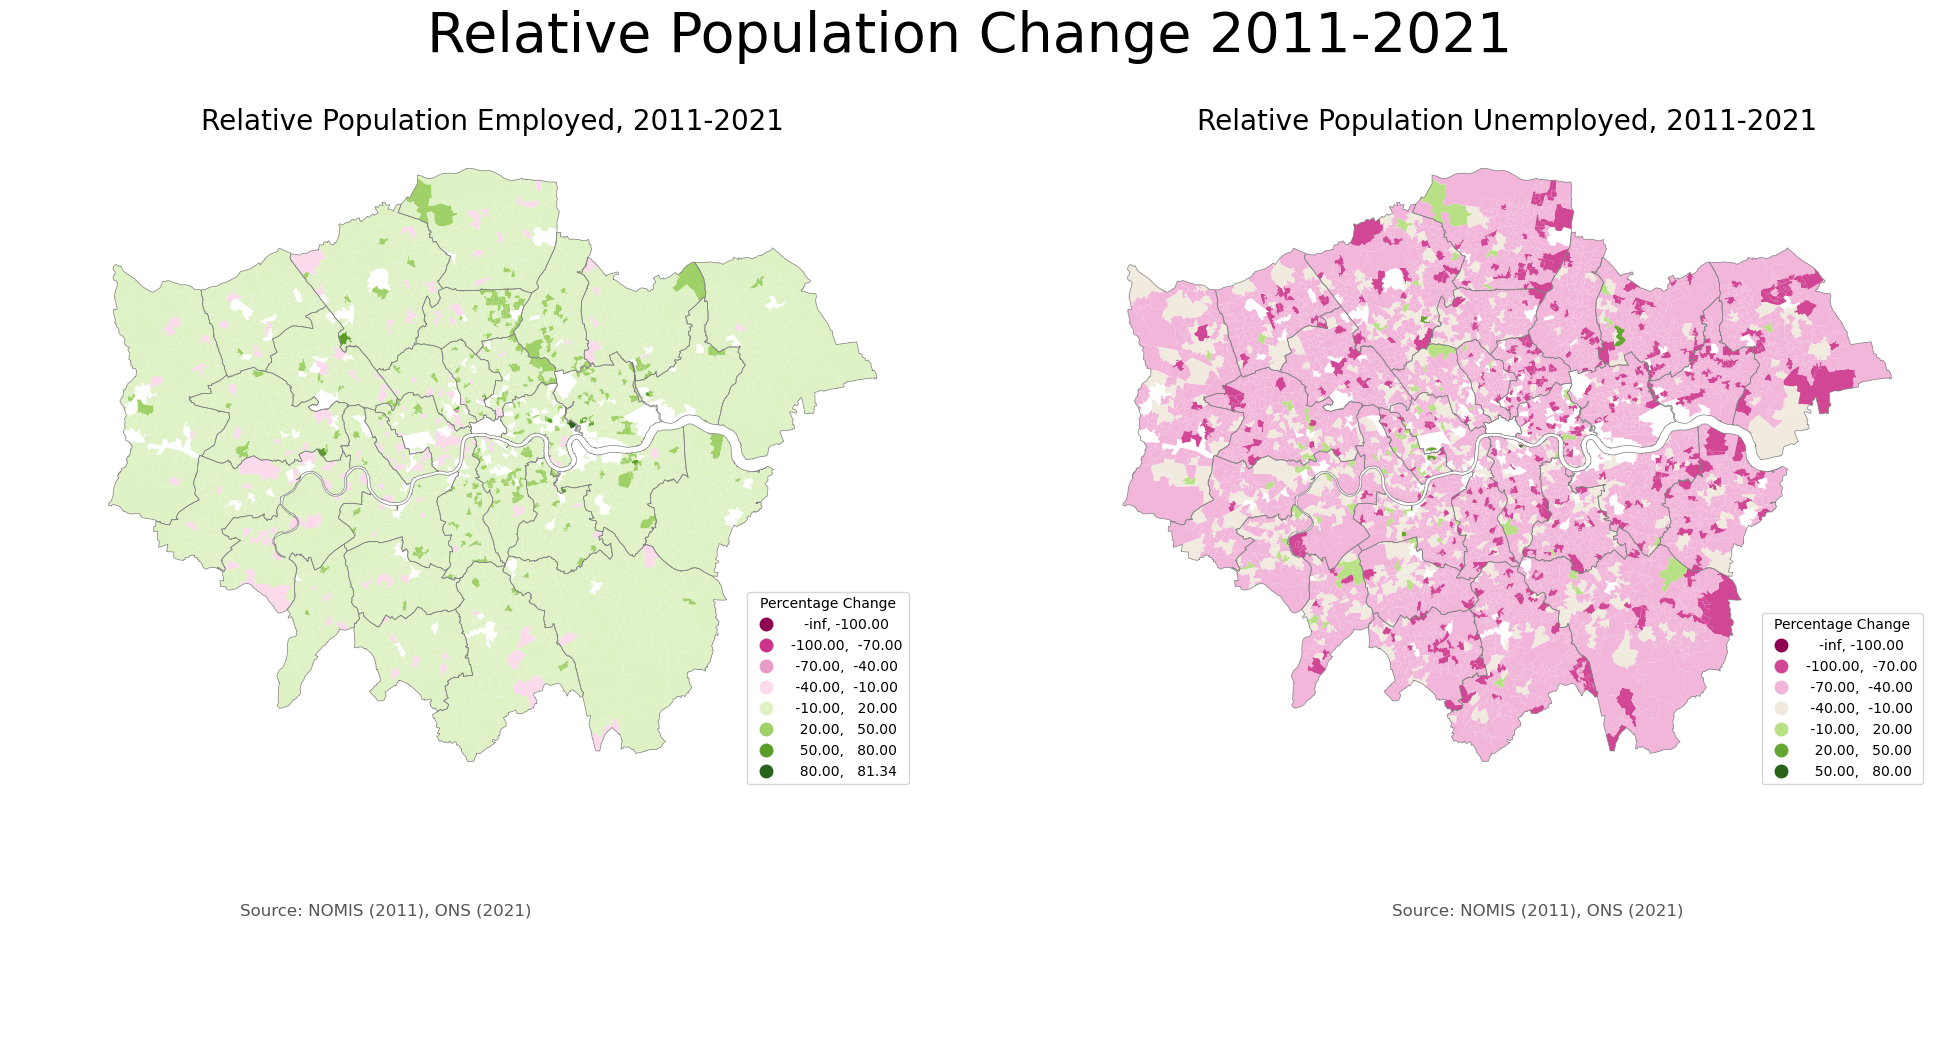

In [61]:
cbins = [x for x in range(-100, 100, 30)] 

fig, axs = plt.subplots(1,2, figsize=(24, 14))   
lsoa_gdf.plot(column='RC_Employed', ax=axs[0],
         scheme='UserDefined', 
         classification_kwds={'bins': cbins},  #Keyword arguments to pass to mapclassify
         cmap = pcd.PiYG_10.mpl_colormap,
         edgecolor='grey', linewidth=0.0,        #change line style
         legend=True, legend_kwds={'title': "Percentage Change",'loc': 'lower right'},
              missing_kwds={"color":"lightgrey",
                           "label":"Split LSOAs"})  

#overlay the borough boundaries
borshp.plot(ax=axs[0], facecolor="none", edgecolor="grey", linewidth=0.5)
axs[0].axis('off') #don't plot the axes (bounding box)
axs[0].set_title('Relative Population Employed, 2011-2021', fontsize=20)  #provide a title
axs[0].annotate('Source: NOMIS (2011), ONS (2021)',
             xy=(0.1, 0.1), xycoords='figure fraction', 
             horizontalalignment='left', verticalalignment='top', 
             fontsize=12, color='#555555')  #add source info on the image itself


lsoa_gdf.plot(column='RC_Unemployed', ax=axs[1],
         scheme='UserDefined', 
         classification_kwds={'bins': cbins},  #Keyword arguments to pass to mapclassify
         cmap = pcd.PiYG_10.mpl_colormap,
         edgecolor='grey', linewidth=0.0,        #change line style
         legend=True, legend_kwds={'title': "Percentage Change",'loc': 'lower right'},
              missing_kwds={"color":"lightgrey",
                           "label":"Split LSOAs"})  

#overlay the borough boundaries
borshp.plot(ax=axs[1], facecolor="none", edgecolor="grey", linewidth=0.5)

axs[1].axis('off') #don't plot the axes (bounding box)
axs[1].set_title('Relative Population Unemployed, 2011-2021', fontsize=20)  #provide a title
axs[1].annotate('Source: NOMIS (2011), ONS (2021)',
             xy=(0.58, 0.1), xycoords='figure fraction', 
             horizontalalignment='left', verticalalignment='top', 
             fontsize=12, color='#555555')


plt.suptitle('Relative Population Change 2011-2021', fontsize=40, y=0.82)
plt.savefig("Relative Pop Change Employed LSOA.png", dpi=300, bbox_inches='tight', facecolor='white')
#plt.savefig("img/Map_LSOAs_PerD_11-21.svg", bbox_inches='tight', facecolor='white')
plt.show()

In [59]:
lsoa_gdf['Diff_Unemployed']= lsoa_gdf['Rel_Unemployed21']-lsoa_gdf['Rel_Unemployed11']
lsoa_gdf['RC_Unemployed']= 100*lsoa_gdf['Diff_Unemployed']/lsoa_gdf['Rel_Unemployed11']

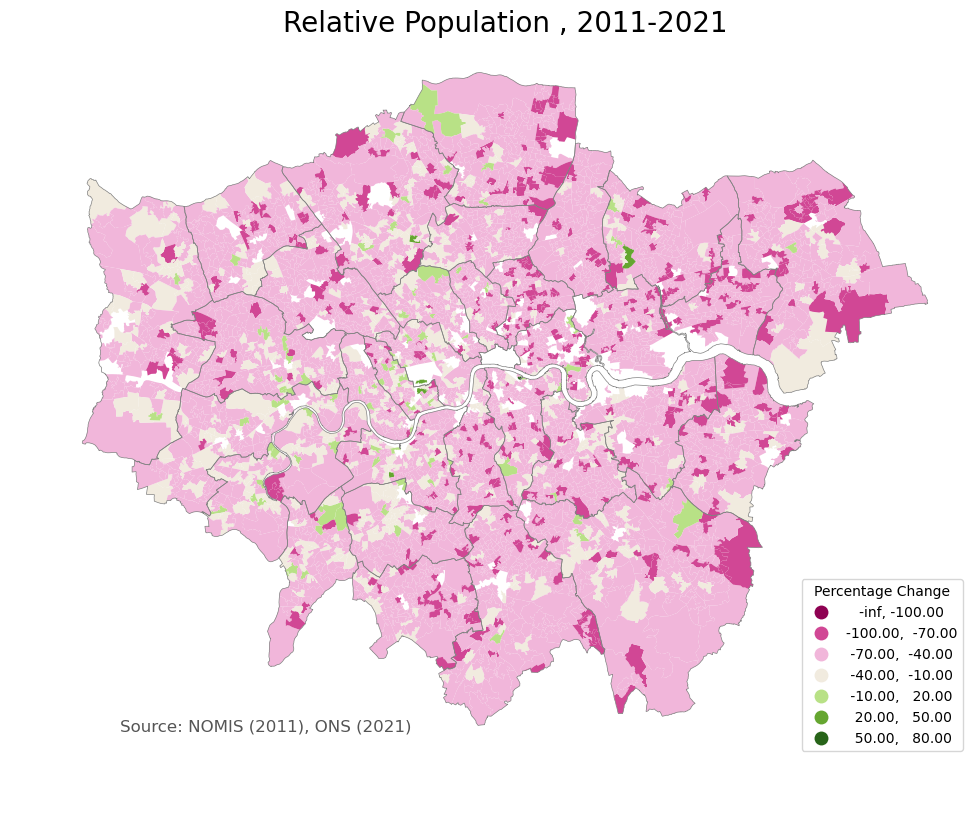

In [60]:
cbins = [x for x in range(-100, 100, 30)] 

fig, ax1 = plt.subplots(1, figsize=(12, 10))   
lsoa_gdf.plot(column='RC_Unemployed', ax=ax1,
         scheme='UserDefined', 
         classification_kwds={'bins': cbins},  #Keyword arguments to pass to mapclassify
         cmap = pcd.PiYG_10.mpl_colormap,
         edgecolor='grey', linewidth=0.0,        #change line style
         legend=True, legend_kwds={'title': "Percentage Change",'loc': 'lower right'},
              missing_kwds={"color":"lightgrey",
                           "label":"Split LSOAs"})  

#overlay the borough boundaries
borshp.plot(ax=ax1, facecolor="none", edgecolor="grey", linewidth=0.5)

ax1.axis('off') #don't plot the axes (bounding box)
plt.title('Relative Population , 2011-2021', fontsize=20)  #provide a title
ax1.annotate('Source: NOMIS (2011), ONS (2021)',
             xy=(0.1, 0.1), xycoords='figure fraction', 
             horizontalalignment='left', verticalalignment='top', 
             fontsize=12, color='#555555')
#plt.savefig("img/Map_LSOAs_PerD_11-21.png", dpi=300, bbox_inches='tight', facecolor='white')
#plt.savefig("img/Map_LSOAs_PerD_11-21.svg", bbox_inches='tight', facecolor='white')
plt.show()

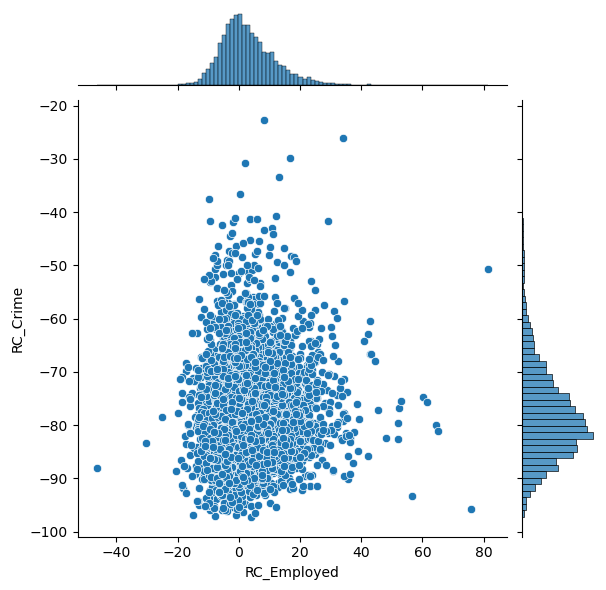

In [55]:
sb.jointplot(x="RC_Employed", y="RC_Crime", data=lsoa_gdf)

In [56]:
print(ss.pearsonr(lsoa_gdf['RC_Employed'].dropna(),lsoa_gdf['RC_Crime'].dropna()))

PearsonRResult(statistic=0.09521719209111693, pvalue=7.611410134090008e-11)


In [57]:
Employment_Crime_mod = smf.ols("RC_Employed ~ RC_Crime", data = lsoa_gdf) 
Employment_Crime_mod_fit = Employment_Crime_mod.fit()
print(Employment_Crime_mod_fit.summary())

                            OLS Regression Results                            
Dep. Variable:            RC_Employed   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     42.55
Date:                Mon, 15 Jan 2024   Prob (F-statistic):           7.61e-11
Time:                        19:27:05   Log-Likelihood:                -17059.
No. Observations:                4653   AIC:                         3.412e+04
Df Residuals:                    4651   BIC:                         3.414e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     11.4444      1.267      9.035      0.0

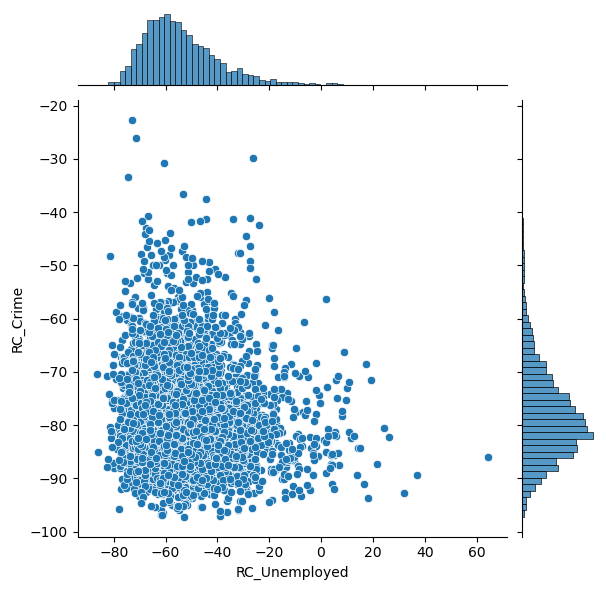

In [62]:
sb.jointplot(x="RC_Unemployed", y="RC_Crime", data=lsoa_gdf)

In [63]:
print(ss.pearsonr(lsoa_gdf['RC_Unemployed'].dropna(),lsoa_gdf['RC_Crime'].dropna()))

PearsonRResult(statistic=-0.0911146466130474, pvalue=4.770337881405778e-10)


In [64]:
Unemployment_Crime_mod = smf.ols("RC_Unemployed ~ RC_Crime", data = lsoa_gdf) 
Unemployment_Crime_mod_fit = Unemployment_Crime_mod.fit()
print(Unemployment_Crime_mod_fit.summary())

                            OLS Regression Results                            
Dep. Variable:          RC_Unemployed   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     38.94
Date:                Mon, 15 Jan 2024   Prob (F-statistic):           4.77e-10
Time:                        19:28:15   Log-Likelihood:                -19356.
No. Observations:                4653   AIC:                         3.872e+04
Df Residuals:                    4651   BIC:                         3.873e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -66.5309      2.075    -32.064      0.0

In [65]:
print(Boroughs_Qual_TR.columns)

Index(['NAME_x', 'GSS_CODE', 'HECTARES', 'NONLD_AREA', 'ONS_INNER', 'SUB_2009',
       'SUB_2006', 'geometry', 'NAME_y', 'BORO', 'TotRes21', 'TotRes11_m21',
       'QualNone21', 'QualNone11_m21', 'QualSch21', 'QualSch11_m21',
       'QualUni21', 'QualUni11_m21', 'Rel_QualNone21', 'Rel_QualNone11',
       'Rel_QualUni21', 'Rel_QualUni11'],
      dtype='object')


In [66]:
print(lsoa_gdf.columns)

Index(['LSOA Code', 'LSOA Name_x', 'Borough_x', 'MSOA21NM', 'LAD22CD',
       'LAD22NM', 'LSOA21KM2', 'LSOAP21', 'CHGIND', 'geometry', 'TotRes21',
       'TotRes11_m21', 'TotHHolds21', 'TotHHolds11_m21', 'FemRes21',
       'FemRes11_m21', 'MalRes21', 'MalRes11_m21', 'Asian21', 'Asian11_m21',
       'Black21', 'Black11_m21', 'MixedE21', 'MixedE11_m21', 'White21',
       'White11_m21', 'OtherE21', 'OtherE11_m21', 'CarsZero21',
       'CarsZero11_m21', 'CarsOne21', 'CarsOne11_m21', 'CarsTwo21',
       'CarsTwo11_m21', 'CarsThrp21', 'CarsThrp11_m21', 'EconEm21',
       'EconEm11_m21', 'EconUn21', 'EconUn11_m21', 'EconSt21', 'EconSt11_m21',
       'EconRe21', 'EconRe11_m21', 'EconOt21', 'EconOt11_m21', 'AgeChild21',
       'AgeChild11_m21', 'AgeAdult21', 'AgeAdult11_m21', 'AgeSenior21',
       'AgeSenior11_m21', 'HealthVG21', 'HealthVG11_m21', 'HealthGood21',
       'HealthGood11_m21', 'HealthFair21', 'HealthFair11_m21', 'HealthBad21',
       'HealthBad11_m21', 'HealthVB21', 'HealthVB11_m21

In [67]:
lsoa_gdf['Rel_TotalCrime21'] = 100*lsoa_gdf['Total Crime 2021']/lsoa_gdf['TotRes21']
lsoa_gdf['Rel_TotalCrime11'] = 100*lsoa_gdf['Total Crime 2011']/lsoa_gdf['TotRes11_m21']

In [68]:
lsoa_gdf['Diff_TotalCrime']=lsoa_gdf['Rel_TotalCrime21']-lsoa_gdf['Rel_TotalCrime11']
lsoa_gdf['RC_TotalCrime']=100*lsoa_gdf['Diff_TotalCrime']/lsoa_gdf['Rel_TotalCrime11']

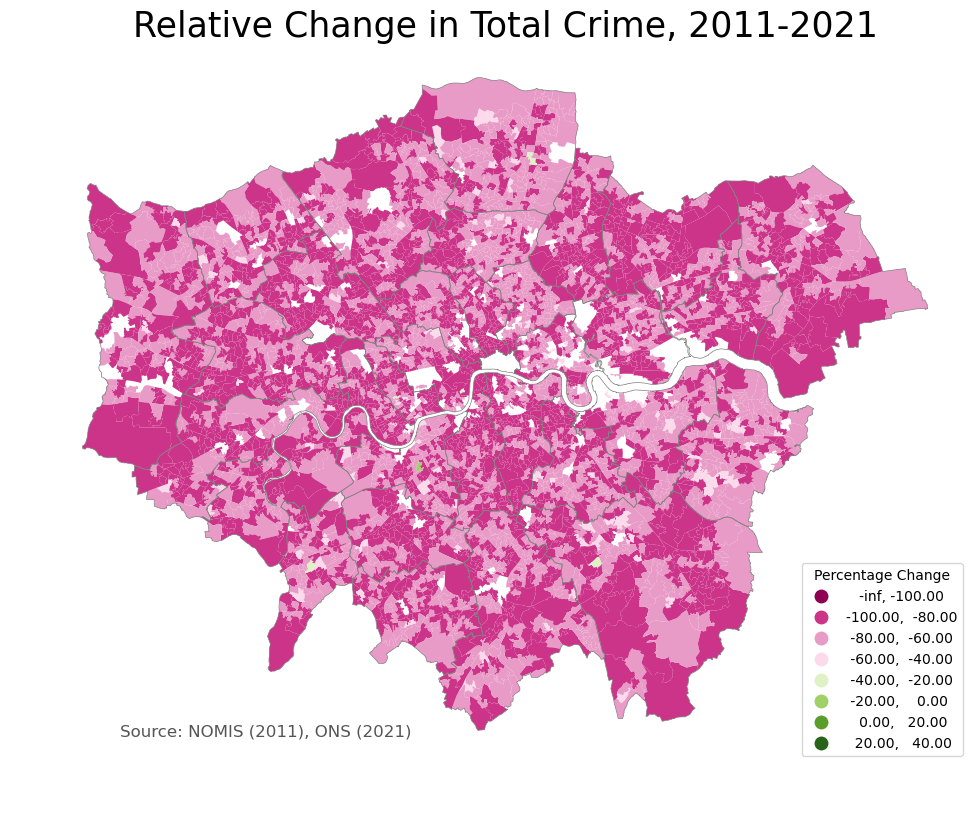

In [69]:
cbins = [x for x in range(-100, 50, 20)] 

fig, ax1 = plt.subplots(1, figsize=(12, 10))   
lsoa_gdf.plot(column='RC_TotalCrime', ax=ax1,
         scheme='UserDefined', 
         classification_kwds={'bins': cbins},  #Keyword arguments to pass to mapclassify
         cmap = pcd.PiYG_10.mpl_colormap,
         edgecolor='grey', linewidth=0.0,        #change line style
         legend=True, legend_kwds={'title': "Percentage Change",'loc': 'lower right'},
              missing_kwds={"color":"lightgrey",
                           "label":"Split LSOAs"})  

#overlay the borough boundaries
borshp.plot(ax=ax1, facecolor="none", edgecolor="grey", linewidth=0.5)

ax1.axis('off') #don't plot the axes (bounding box)

plt.title('Relative Change in Total Crime, 2011-2021', fontsize=25)  #provide a title

ax1.annotate('Source: NOMIS (2011), ONS (2021)',
             xy=(0.1, 0.1), xycoords='figure fraction', 
             horizontalalignment='left', verticalalignment='top', 
             fontsize=12, color='#555555')  #add source info on the image itself

plt.savefig("Relative Change in Total Crime, 2011-2021.png", dpi=300, bbox_inches='tight', facecolor='white')
#plt.savefig("img/Map_LSOAs_PerD_11-21.svg", bbox_inches='tight', facecolor='white')

plt.show()

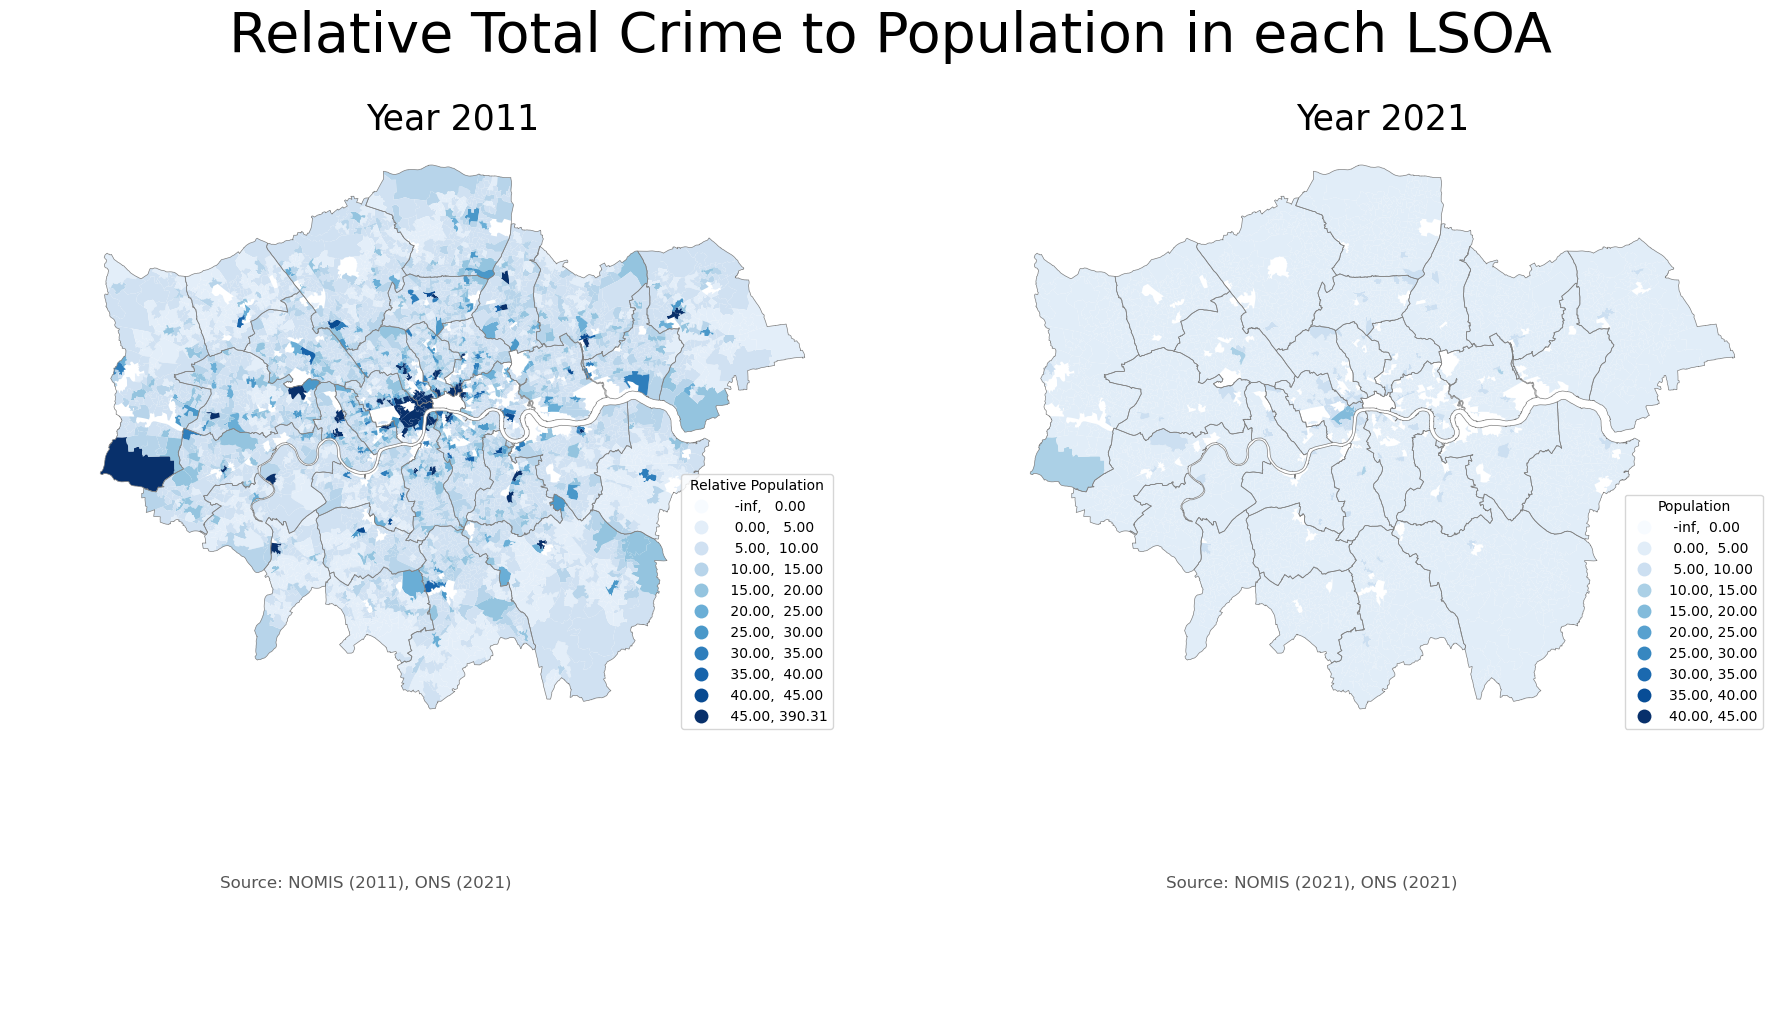

In [70]:
cbins = [x for x in range(0, 50, 5)]  

fig, axs = plt.subplots(1,2,figsize=(22,14))
lsoa_gdf.plot(column='Rel_TotalCrime11', ax=axs[0],
         scheme='UserDefined', 
         classification_kwds={'bins': cbins}, 
         cmap = 'Blues',
         edgecolor='grey', linewidth=0.0,       
         legend=True, legend_kwds={'title': "Relative Population",'loc': 'lower right'})  

borshp.plot(ax=axs[0], facecolor="none", edgecolor="grey", linewidth=0.5)
axs[0].axis('off')
axs[0].set_title('Year 2011', fontsize=25) 
axs[0].annotate('Source: NOMIS (2011), ONS (2021)',
             xy=(0.1, 0.1), xycoords='figure fraction', 
             horizontalalignment='left', verticalalignment='top', 
             fontsize=12, color='#555555') 

#plt.savefig("img/Map_LSOAs_PerD_11-21.png", dpi=300, bbox_inches='tight', facecolor='white')
#plt.savefig("img/Map_LSOAs_PerD_11-21.svg", bbox_inches='tight', facecolor='white')



lsoa_gdf.plot(column='Rel_TotalCrime21', ax=axs[1],
         scheme='UserDefined', 
         classification_kwds={'bins': cbins},  
         cmap = 'Blues',
         edgecolor='grey', linewidth=0.0,    
         legend=True, legend_kwds={'title': "Population",'loc': 'lower right'})  


borshp.plot(ax=axs[1], facecolor="none", edgecolor="grey", linewidth=0.5)
axs[1].axis('off')
axs[1].set_title('Year 2021', fontsize=25) 
axs[1].annotate('Source: NOMIS (2021), ONS (2021)',
             xy=(0.53, 0.1), xycoords='figure fraction', 
             horizontalalignment='left', verticalalignment='top', 
             fontsize=12, color='#555555')
    
plt.suptitle('Relative Total Crime to Population in each LSOA', fontsize=40, y=0.80)
plt.savefig("Relative Total Crime to Population in each LSOA.png", dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

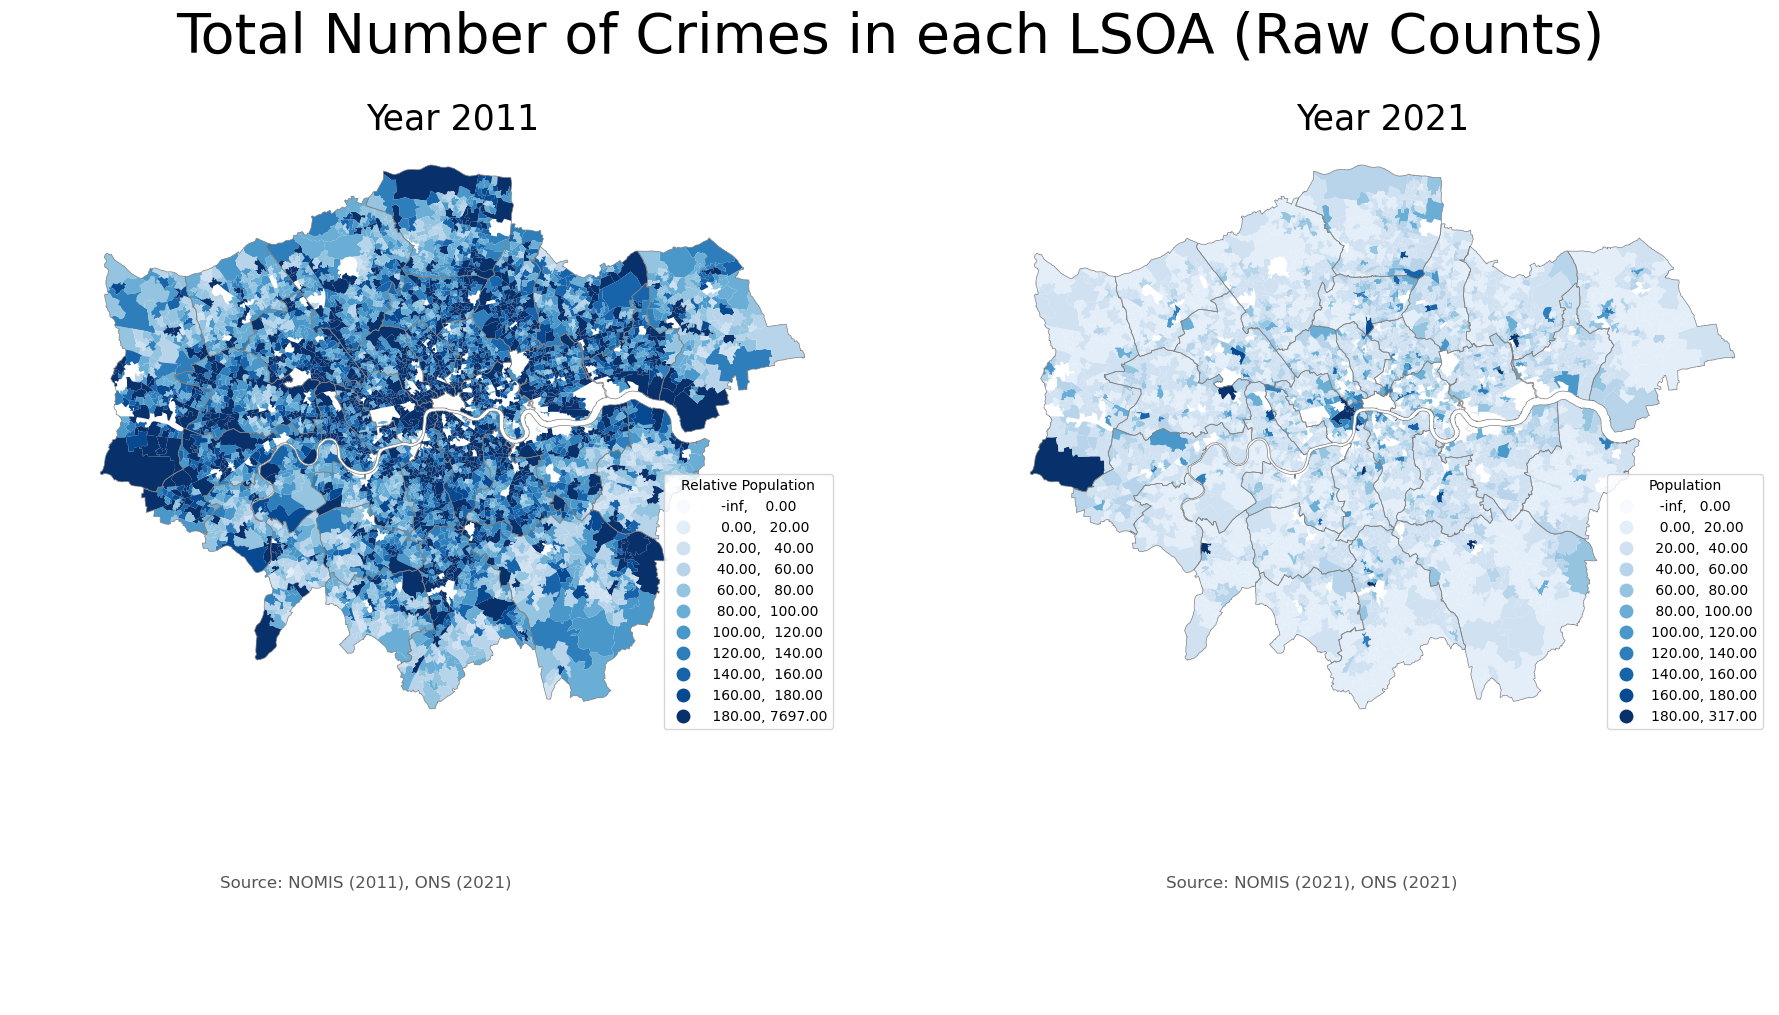

In [71]:
cbins = [x for x in range(0, 200, 20)]  

fig, axs = plt.subplots(1,2,figsize=(22,14))
lsoa_gdf.plot(column='Total Crime 2011', ax=axs[0],
         scheme='UserDefined', 
         classification_kwds={'bins': cbins}, 
         cmap = 'Blues',
         edgecolor='grey', linewidth=0.0,       
         legend=True, legend_kwds={'title': "Relative Population",'loc': 'lower right'})  

borshp.plot(ax=axs[0], facecolor="none", edgecolor="grey", linewidth=0.5)
axs[0].axis('off')
axs[0].set_title('Year 2011', fontsize=25) 
axs[0].annotate('Source: NOMIS (2011), ONS (2021)',
             xy=(0.1, 0.1), xycoords='figure fraction', 
             horizontalalignment='left', verticalalignment='top', 
             fontsize=12, color='#555555') 

#plt.savefig("img/Map_LSOAs_PerD_11-21.png", dpi=300, bbox_inches='tight', facecolor='white')
#plt.savefig("img/Map_LSOAs_PerD_11-21.svg", bbox_inches='tight', facecolor='white')



lsoa_gdf.plot(column='Total Crime 2021', ax=axs[1],
         scheme='UserDefined', 
         classification_kwds={'bins': cbins},  
         cmap = 'Blues',
         edgecolor='grey', linewidth=0.0,    
         legend=True, legend_kwds={'title': "Population",'loc': 'lower right'})  


borshp.plot(ax=axs[1], facecolor="none", edgecolor="grey", linewidth=0.5)
axs[1].axis('off')
axs[1].set_title('Year 2021', fontsize=25) 
axs[1].annotate('Source: NOMIS (2021), ONS (2021)',
             xy=(0.53, 0.1), xycoords='figure fraction', 
             horizontalalignment='left', verticalalignment='top', 
             fontsize=12, color='#555555')
    
plt.suptitle('Total Number of Crimes in each LSOA (Raw Counts)', fontsize=40, y=0.80)
plt.savefig("Total Number of Crimes in each LSOA (Raw Counts).png", dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

In [72]:
#Plot for Boroughs

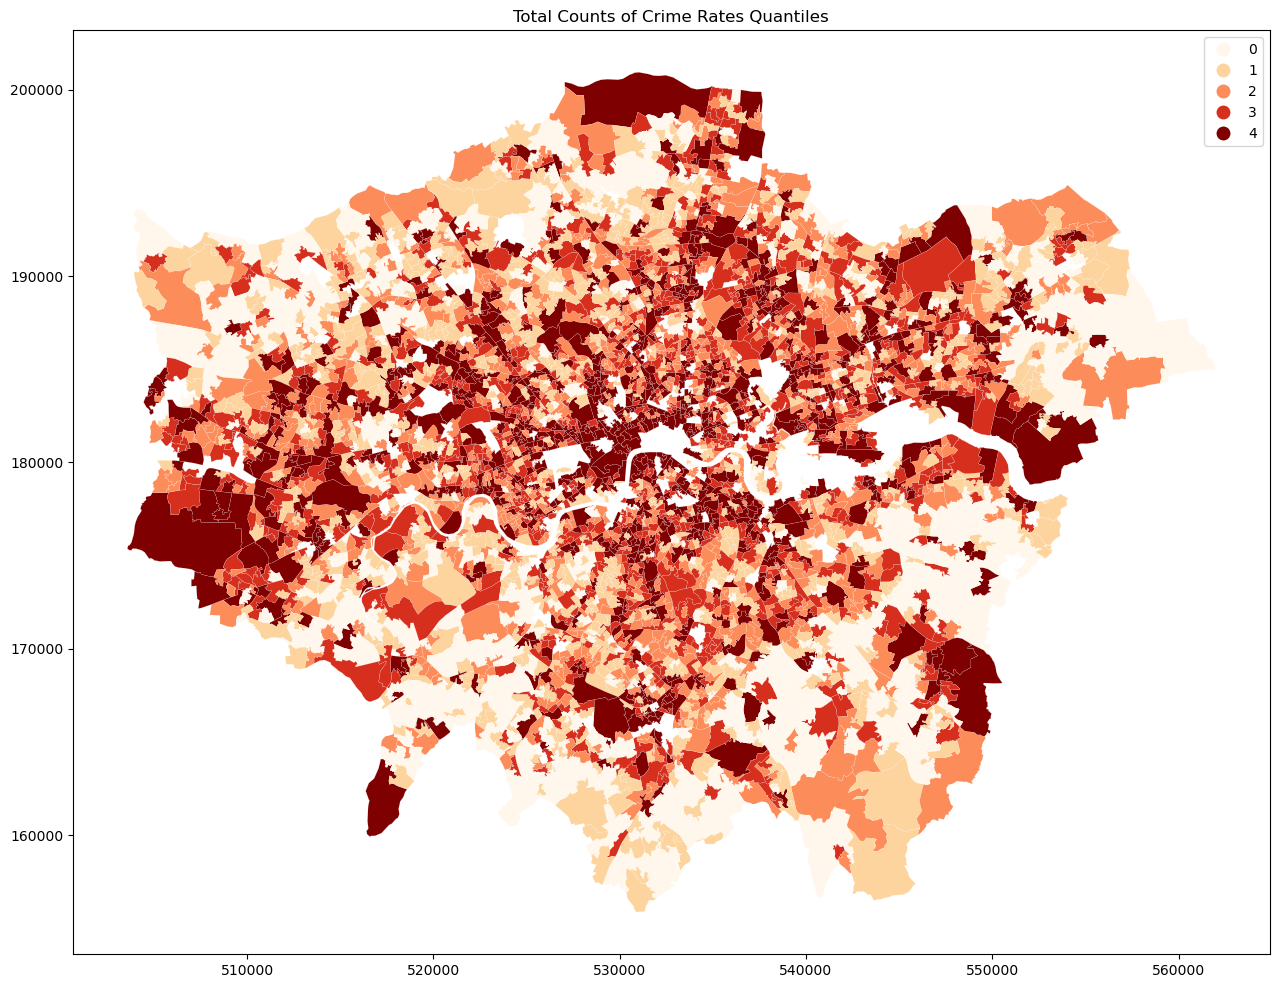

In [74]:
#Calculating Spatial Lag for Total Crime Rates
import pysal as ps
import pysal.viz as viz

SpatialLagTotalCrime21 = ps.viz.mapclassify.Quantiles(lsoa_gdf['Total Crime 2011'],k=5)
f,ax = plt.subplots(1, figsize=(20,12))
lsoa_gdf.assign(cluster_SpatialLagTotalCrime21=SpatialLagTotalCrime21.yb).plot(column='cluster_SpatialLagTotalCrime21',categorical=True,k=5,cmap='OrRd',
                                                                               linewidth=0.1,ax=ax,edgecolor='white',legend=True)

plt.title('Total Counts of Crime Rates Quantiles')
plt.show()

In [78]:
import pysal.lib
import libpysal as lps

# Assuming lsoa_gdf is a GeoDataFrame containing spatial data

# Create a Queen contiguity weights matrix
w_queen = pysal.lib.weights.Queen.from_dataframe(lsoa_gdf)

# Optionally, you can transform the weights to be row-standardized
w_queen.transform = 'r'

# Now, w_queen is your Queen contiguity spatial weights matrix

('WARNING: ', 4473, ' is an island (no neighbors)')
('WARNING: ', 4611, ' is an island (no neighbors)')


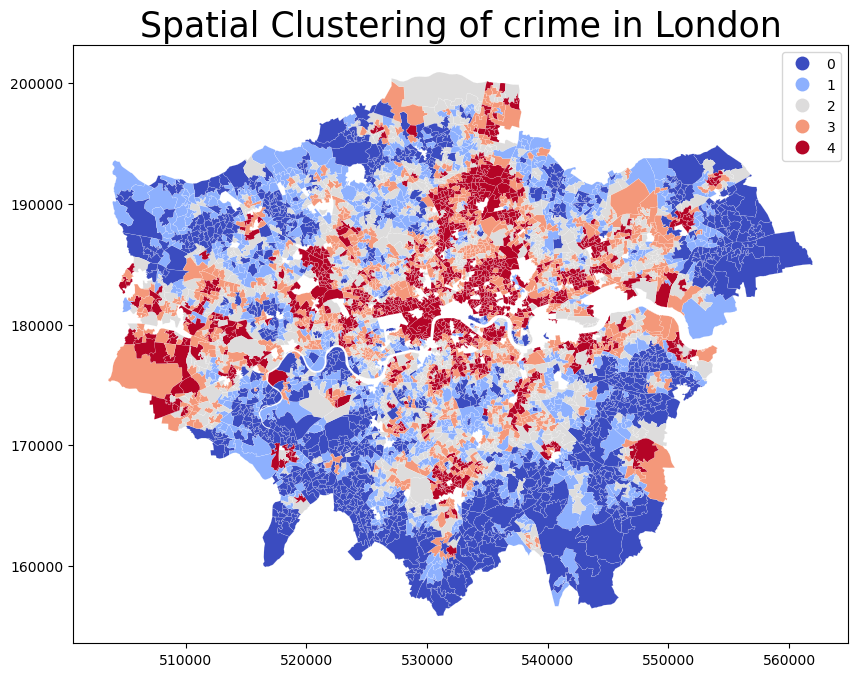

In [90]:
crime_lag = lps.weights.lag_spatial(w_queen, lsoa_gdf['Total Crime 2021'])
crime_lagQ5 = ps.viz.mapclassify.Quantiles(crime_lag, k=5)

f, ax = plt.subplots(1,figsize=(10,8))
lsoa_gdf.assign(cl_lag=crime_lagQ5.yb).plot(column='cl_lag', categorical=True, k=5, cmap='coolwarm',linewidth=0.1, ax=ax, edgecolor='white', legend=True)
plt.title("Spatial Clustering of crime in London", fontsize=25)
plt.savefig("Spatial Clustering of Crime in London.png", dpi=300, bbox_inches='tight', facecolor='white')

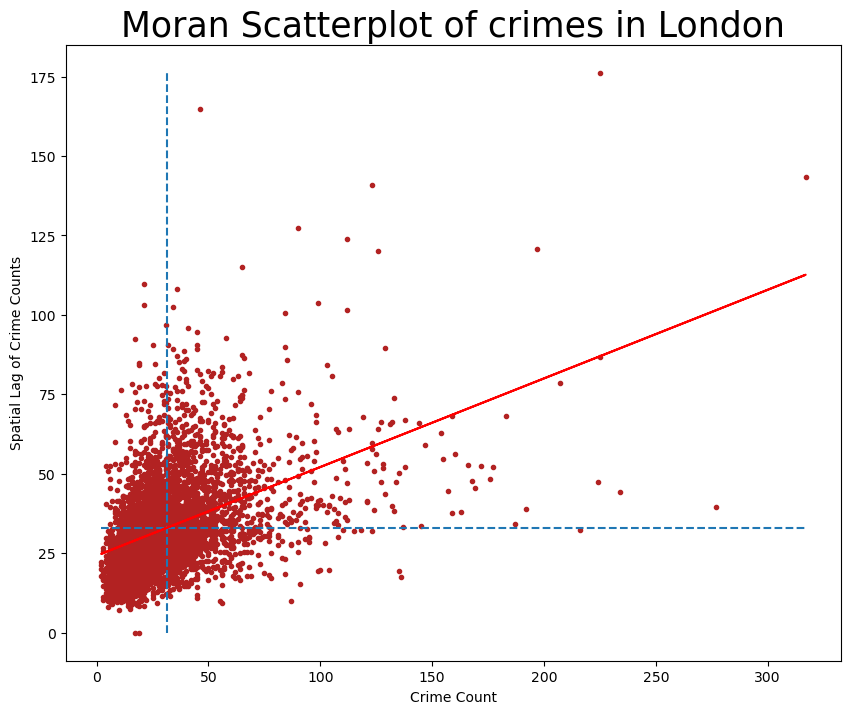

In [92]:
crime=lsoa_gdf['Total Crime 2021']
b,a = np.polyfit(crime, crime_lag, 1)
f, ax = plt.subplots(1, figsize=(10,8))
plt.plot(crime, crime_lag,'.',color='firebrick')

plt.vlines(crime.mean(), crime_lag.min(), crime_lag.max(), linestyle='--')
plt.hlines(crime_lag.mean(), crime.min(), crime.max(), linestyle='--')

plt.plot(crime, a + b*crime, 'r')
plt.title('Moran Scatterplot of crimes in London', fontsize=25)
plt.ylabel('Spatial Lag of Crime Counts')
plt.xlabel('Crime Count')
plt.savefig("Moran Scatterplot of crimes in London.png", dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

In [81]:
import esda
lisa = esda.Moran_Local(lsoa_gdf['Total Crime 2021'].values, w_queen, permutations=999)
lisa.Is

array([ 0.10355445,  2.35731737,  0.57103174, ...,  0.01715213,
       -0.40727904,  0.05987832])

In [82]:
lisa.q

array([1, 1, 1, ..., 1, 2, 1])

In [83]:
lisa.p_sim

array([0.137, 0.092, 0.021, ..., 0.356, 0.136, 0.141])

In [84]:
(lisa.p_sim < 0.05).sum()

1100

In [85]:
lsoa_gdf['lag_crime'] = lps.weights.lag_spatial(w_queen, lsoa_gdf['Total Crime 2021'])
sigs = lsoa_gdf['Total Crime 2021'][lisa.p_sim <= .05]
W_sigs = lsoa_gdf['lag_crime'][lisa.p_sim <= .05]
insigs = lsoa_gdf['Total Crime 2021'][lisa.p_sim > .05]
W_insigs = lsoa_gdf['lag_crime'][lisa.p_sim > .05]

In [86]:
!pip install splot

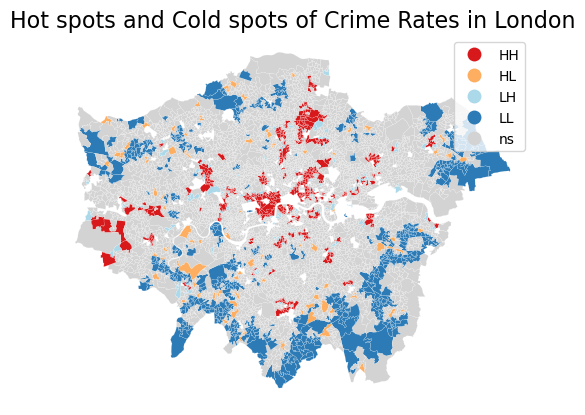

In [94]:
from splot.esda import lisa_cluster
fig = lisa_cluster(lisa, lsoa_gdf)
plt.title("Hot spots and Cold spots of Crime Rates in London", fontsize=16)
plt.savefig("Hot spots and Cold spots of Crime Rates in London.png", dpi=300, bbox_inches='tight', facecolor='white')

In [88]:
sig = lisa.p_sim < 0.05
hotspot = sig * lisa.q==1
coldspot = sig * lisa.q==3
doughnut = sig * lisa.q==2
diamond = sig * lisa.q==4